In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from scipy.interpolate import griddata
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.io import arff
from scipy.stats import kruskal

### Analiza zbioru

In [2]:
data, meta = arff.loadarff('seismic-bumps.arff')
df = pd.DataFrame(data)

for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')
df.head()

seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls ghazard  \
0       a              a     N  15180.0   48.0     -72.0   -72.0       a   
1       a              a     N  14720.0   33.0     -70.0   -79.0       a   
2       a              a     N   8050.0   30.0     -81.0   -78.0       a   
3       a              a     N  28820.0  171.0     -23.0    40.0       a   
4       a              a     N  12640.0   57.0     -63.0   -52.0       a   

   nbumps  nbumps2  nbumps3  nbumps4  nbumps5  nbumps6  nbumps7  nbumps89  \
0     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
1     1.0      0.0      1.0      0.0      0.0      0.0      0.0       0.0   
2     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
3     1.0      0.0      1.0      0.0      0.0      0.0      0.0       0.0   
4     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   

   energy  maxenergy class  
0     0.0        0.0     0  
1  2000.0     2000.0     0  
2     0.0        0.0     0  
3  3000.0     3000.0     0  
4     0.0        0.0     0

In [3]:
df.shape

(2584, 19)

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seismic         2584 non-null   str    
 1   seismoacoustic  2584 non-null   str    
 2   shift           2584 non-null   str    
 3   genergy         2584 non-null   float64
 4   gpuls           2584 non-null   float64
 5   gdenergy        2584 non-null   float64
 6   gdpuls          2584 non-null   float64
 7   ghazard         2584 non-null   str    
 8   nbumps          2584 non-null   float64
 9   nbumps2         2584 non-null   float64
 10  nbumps3         2584 non-null   float64
 11  nbumps4         2584 non-null   float64
 12  nbumps5         2584 non-null   float64
 13  nbumps6         2584 non-null   float64
 14  nbumps7         2584 non-null   float64
 15  nbumps89        2584 non-null   float64
 16  energy          2584 non-null   float64
 17  maxenergy       2584 non-null   float64
 18 

### Informacje o atrybutach:

1. seismic: wynik zmianowej oceny zagrożenia sejsmicznego w wyrobisku górniczym uzyskany metodą sejsmiczną
(a – brak zagrożenia, b – niskie zagrożenie, c – wysokie zagrożenie, d – stan zagrożenia);

2. seismoacoustic: wynik zmianowej oceny zagrożenia sejsmicznego w wyrobisku górniczym uzyskany metodą sejsmoakustyczną;

3. shift: informacja o rodzaju zmiany
(W – zmiana wydobywcza, N – zmiana przygotowawcza);

4. genergy: energia sejsmiczna zarejestrowana podczas poprzedniej zmiany przez najbardziej aktywny geofon (GMax) spośród geofonów monitorujących ścianę;

5. gpuls: liczba impulsów zarejestrowanych podczas poprzedniej zmiany przez GMax;

6. gdenergy: odchylenie energii zarejestrowanej podczas poprzedniej zmiany przez GMax od średniej energii zarejestrowanej w ośmiu poprzednich zmianach;

7. gdpuls: odchylenie liczby impulsów zarejestrowanych podczas poprzedniej zmiany przez GMax od średniej liczby impulsów zarejestrowanych w ośmiu poprzednich zmianach;

8. ghazard: wynik zmianowej oceny zagrożenia sejsmicznego w wyrobisku górniczym uzyskany metodą sejsmoakustyczną na podstawie rejestracji wyłącznie z GMax;

9. nbumps: liczba wstrząsów sejsmicznych zarejestrowanych podczas poprzedniej zmiany;

10. nbumps2: liczba wstrząsów sejsmicznych (w zakresie energii [10², 10³)) zarejestrowanych podczas poprzedniej zmiany;

11. nbumps3: liczba wstrząsów sejsmicznych (w zakresie energii [10³, 10⁴)) zarejestrowanych podczas poprzedniej zmiany;

12. nbumps4: liczba wstrząsów sejsmicznych (w zakresie energii [10⁴, 10⁵)) zarejestrowanych podczas poprzedniej zmiany;

13. nbumps5: liczba wstrząsów sejsmicznych (w zakresie energii [10⁵, 10⁶)) zarejestrowanych podczas ostatniej zmiany;

14. nbumps6: liczba wstrząsów sejsmicznych (w zakresie energii [10⁶, 10⁷)) zarejestrowanych podczas poprzedniej zmiany;

15. nbumps7: liczba wstrząsów sejsmicznych (w zakresie energii [10⁷, 10⁸)) zarejestrowanych podczas poprzedniej zmiany;

16. nbumps89: liczba wstrząsów sejsmicznych (w zakresie energii [10⁸, 10¹⁰)) zarejestrowanych podczas poprzedniej zmiany;

17. energy: całkowita energia wstrząsów sejsmicznych zarejestrowanych podczas poprzedniej zmiany;

18. maxenergy: maksymalna energia wstrząsu sejsmicznego zarejestrowanego podczas poprzedniej zmiany;

19. class: atrybut decyzyjny — „1” oznacza wystąpienie wstrząsu sejsmicznego o wysokiej energii w następnej zmianie
(„stan zagrożenia”), natomiast „0” oznacza brak wystąpienia wstrząsów sejsmicznych o wysokiej energii w następnej zmianie
(„stan niezagrożony”).

In [5]:
df.isnull().sum()

seismic           0
seismoacoustic    0
shift             0
genergy           0
gpuls             0
gdenergy          0
gdpuls            0
ghazard           0
nbumps            0
nbumps2           0
nbumps3           0
nbumps4           0
nbumps5           0
nbumps6           0
nbumps7           0
nbumps89          0
energy            0
maxenergy         0
class             0
dtype: int64

In [6]:
df.describe()

genergy        gpuls     gdenergy       gdpuls       nbumps  \
count  2.584000e+03  2584.000000  2584.000000  2584.000000  2584.000000   
mean   9.024252e+04   538.579334    12.375774     4.508901     0.859520   
std    2.292005e+05   562.652536    80.319051    63.166556     1.364616   
min    1.000000e+02     2.000000   -96.000000   -96.000000     0.000000   
25%    1.166000e+04   190.000000   -37.000000   -36.000000     0.000000   
50%    2.548500e+04   379.000000    -6.000000    -6.000000     0.000000   
75%    5.283250e+04   669.000000    38.000000    30.250000     1.000000   
max    2.595650e+06  4518.000000  1245.000000   838.000000     9.000000   

           nbumps2      nbumps3      nbumps4      nbumps5  nbumps6  nbumps7  \
count  2584.000000  2584.000000  2584.000000  2584.000000   2584.0   2584.0   
mean      0.393576     0.392802     0.067724     0.004644      0.0      0.0   
std       0.783772     0.769710     0.279059     0.068001      0.0      0.0   
min       0.000000     0.000000     0.000000     0.000000      0.0      0.0   
25%       0.000000     0.000000     0.000000     0.000000      0.0      0.0   
50%       0.000000     0.000000     0.000000     0.000000      0.0      0.0   
75%       1.000000     1.000000     0.000000     0.000000      0.0      0.0   
max       8.000000     7.000000     3.000000     1.000000      0.0      0.0   

       nbumps89         energy      maxenergy  
count    2584.0    2584.000000    2584.000000  
mean        0.0    4975.270898    4278.850619  
std         0.0   20450.833222   19357.454882  
min         0.0       0.000000       0.000000  
25%         0.0       0.000000       0.000000  
50%         0.0       0.000000       0.000000  
75%         0.0    2600.000000    2000.000000  
max         0.0  402000.000000  400000.000000

Sprawdzamy jak faktycznie wyglądają kolumny nbumps

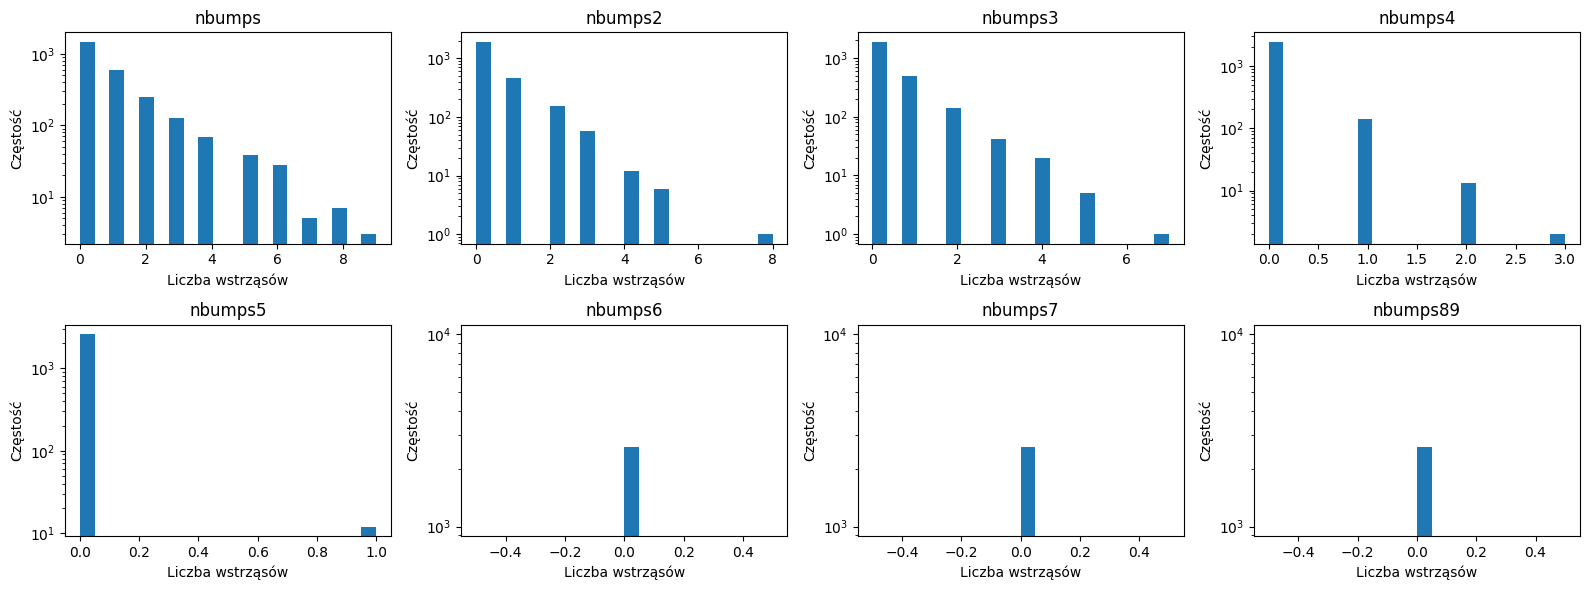

In [7]:
cols = [
    "nbumps", "nbumps2", "nbumps3", "nbumps4",
    "nbumps5", "nbumps6", "nbumps7", "nbumps89"
]

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    ax.hist(df[col], bins=20)
    ax.set_title(col)
    ax.set_yscale("log")  # kluczowe
    ax.set_xlabel("Liczba wstrząsów")
    ax.set_ylabel("Częstość")

plt.tight_layout()
plt.show()

Widzimy, że kolumny z mocniejszymi wstrząsami generalnie nie posiadają zbyt różnorodnych danych - w większości tych wstrząsów w ogóle nie zarejestrowano. Aby ograniczyć ilość danych zerowych ale jednocześnie nie zatracić całkowicie tych informacji - mogą być one kluczowe w predykcji - zdecydowałam się na pozostawienie kolumny nbumps opisującej ogólną ilość wszystkich wstrząsów oraz stworzenie kolumny przypisującej kategorię najmocniejszego zarejestrowanego wstrząsu.

In [8]:
nbumps_cols = ['nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89']

def max_bump_class(row):
    for col in reversed(nbumps_cols):
        if row[col] > 0:
            return int(col.replace('nbumps', ''))
    return 0

df['max_bump_class'] = df[nbumps_cols].apply(max_bump_class, axis=1)

cols = df.columns.tolist()
cols.remove('max_bump_class')
cols.insert(-1, 'max_bump_class')
df = df[cols]

df.drop(columns=nbumps_cols, inplace=True)

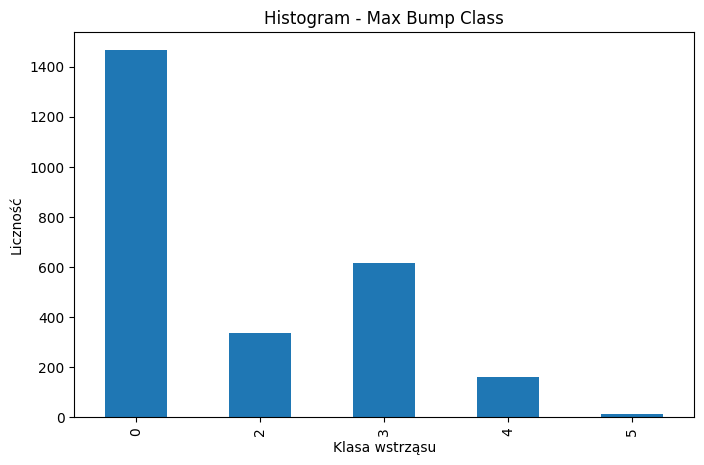

In [9]:
plt.figure(figsize=(8, 5))
df['max_bump_class'].value_counts().sort_index().plot(kind='bar')
plt.title("Histogram - Max Bump Class")
plt.xlabel("Klasa wstrząsu")
plt.ylabel("Liczność")
plt.show()

Sprawdzamy rozkład klasy decyzyjnej "class"

In [10]:
df["class"].value_counts().sort_index()

class
0    2414
1     170
Name: count, dtype: int64

<Axes: title={'center': 'Dystrybucja klas'}, xlabel='Klasa', ylabel='Liczba próbek'>

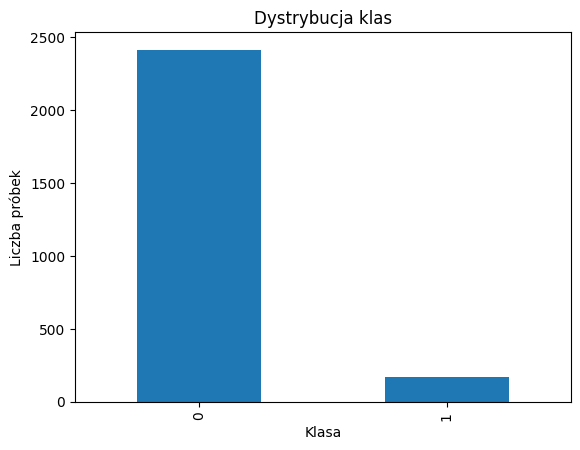

In [11]:
df['class'].value_counts().plot(kind='bar', title='Dystrybucja klas', xlabel='Klasa', ylabel='Liczba próbek')

Widzimy znaczną różnicę w liczności klas (zdecydowanie częściej zarejestrowano brak wstrząsu), dlatego w celu porównania wyników i ewentualnego ich poprawienia w części preprocessingu stworzymy dodatkowy zbiór treningowy z zastosowaniem SMOTE.

C:\Users\grazi\AppData\Local\Temp\ipykernel_41040\1979120929.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include=['object', 'category']).columns


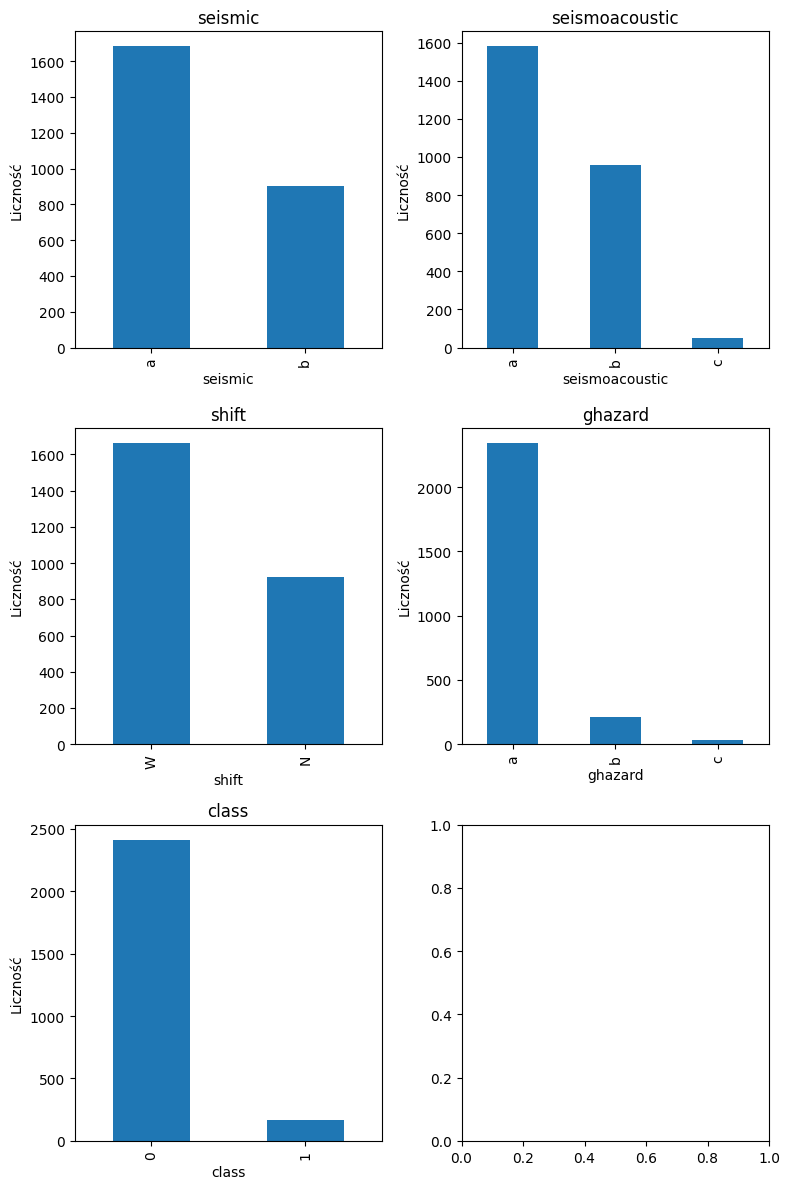

In [12]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel("Liczność")
    
plt.tight_layout()
plt.show()

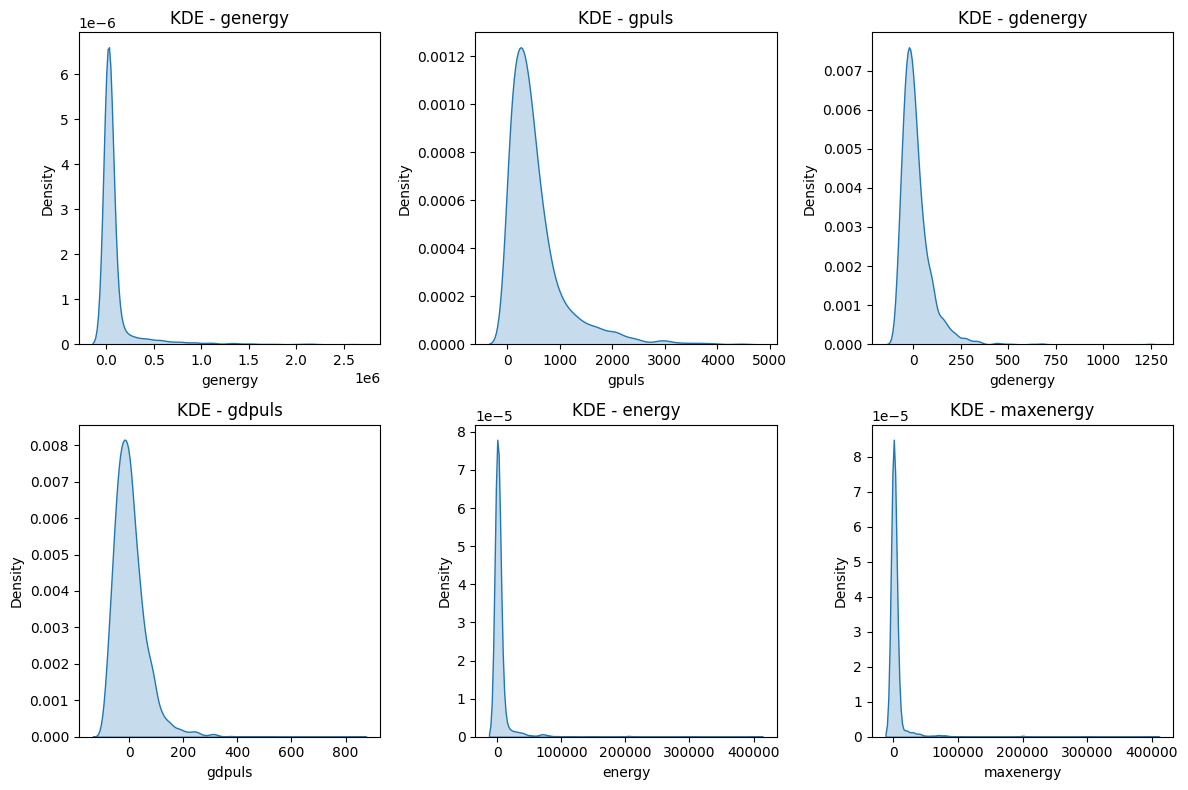

In [13]:
num_cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy', 'maxenergy']

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df, x=col, ax=axes[i], fill=True)
    axes[i].set_title(f"KDE - {col}")

# Usuwamy puste podwykresy
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Można dostrzec silną prawoskośność rozkładów danych z przewagą w niskich wartościach bliskich zeru oraz obecność długich ogonów co wskazuje na brak normalności rozkładów i silną obecność obserwacji odstających.


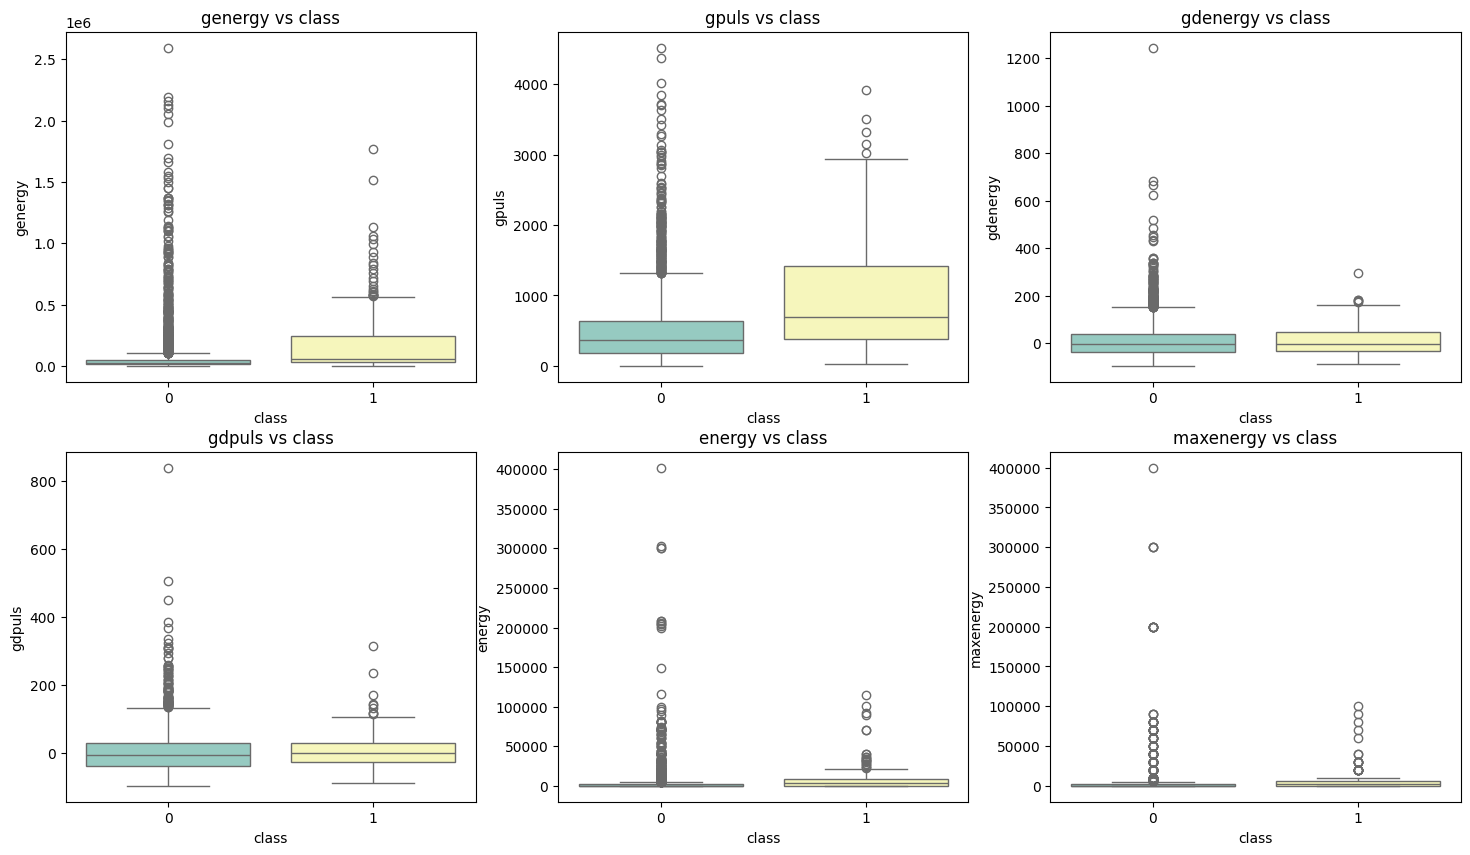

In [14]:
num_cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy', 'maxenergy']

plt.figure(figsize=(18, 10)) 
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="class", y=col, hue="class", data=df, palette="Set3", legend=False)
    plt.title(f"{col} vs class")
    plt.xlabel("class")
    plt.ylabel(col)
plt.show()

Tu tym bardziej widać jak wiele jest wartości odstających i jak bardzo ten zbiór odbiega od rozkładu normalnego.

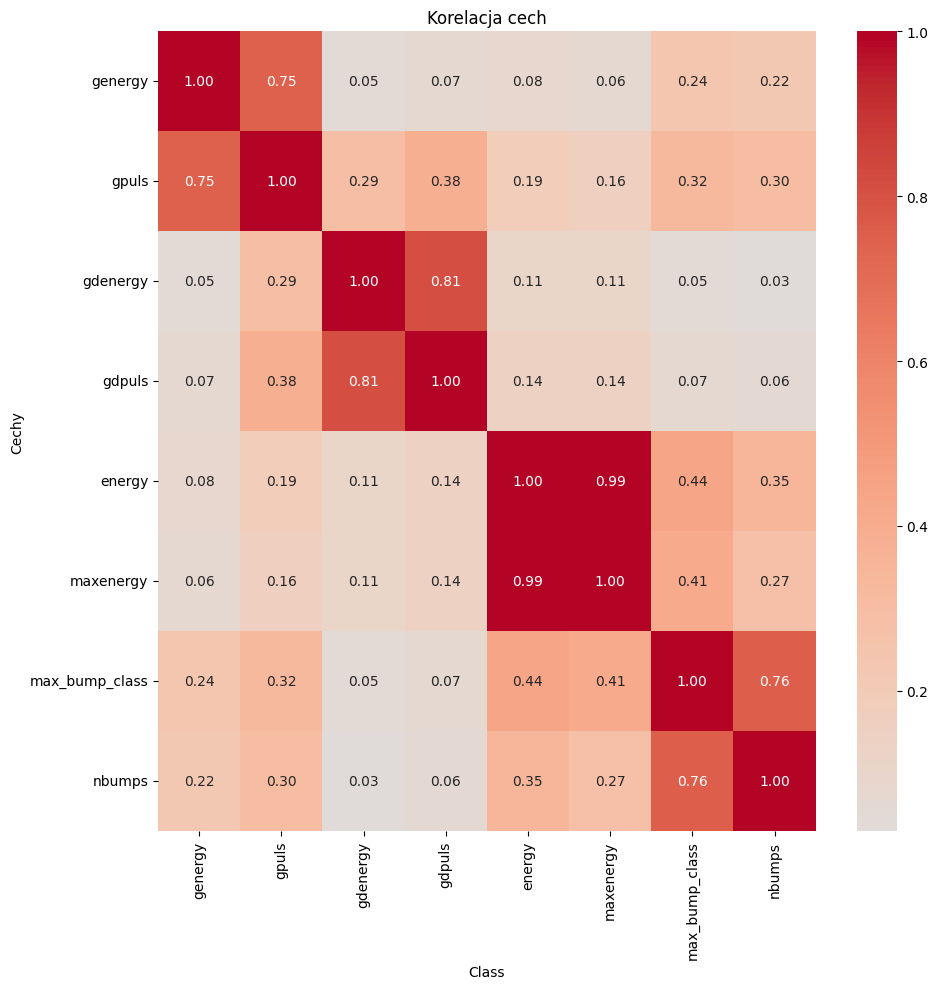

In [15]:
num_cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy', 'maxenergy', 'max_bump_class', 'nbumps']
corr = df[num_cols].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True
)

plt.title("Korelacja cech")
plt.ylabel("Cechy")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

Z powodu bardzo silnej korelacji pomiędzy cechami energy i max energy - co było do przewidzenia decyduję się usunąć kolumnę maxenergy w celu uzyskania lepszych predykcji

In [16]:
df.drop(columns='maxenergy', inplace=True)

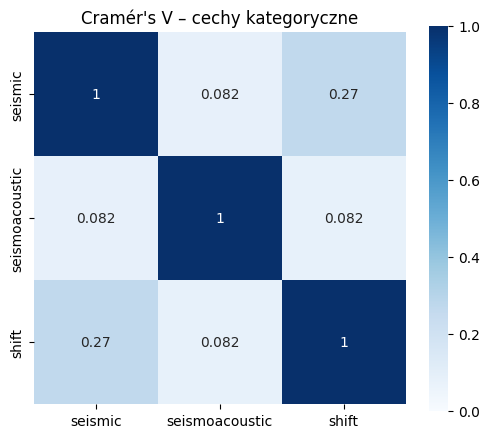

In [17]:
from scipy.stats import chi2_contingency
cat_cols = ['seismic', 'seismoacoustic', 'shift']

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

cramers_matrix = pd.DataFrame(
    [[cramers_v(df[c1], df[c2]) for c2 in cat_cols] for c1 in cat_cols],
    index=cat_cols,
    columns=cat_cols
)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cramers_matrix,
    annot=True,
    cmap='Blues',
    vmin=0, vmax=1,
    square=True
)
plt.title("Cramér's V – cechy kategoryczne")
plt.show()

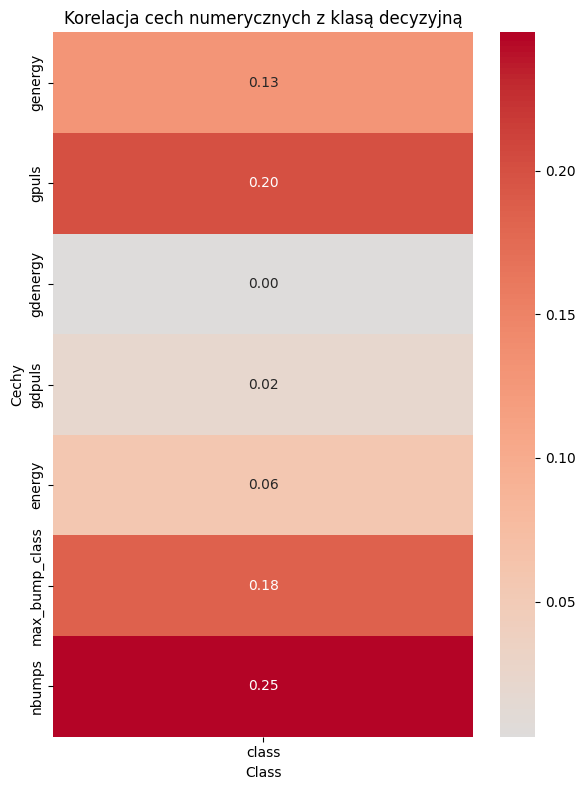

In [18]:
num_cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy', 'max_bump_class', 'nbumps', 'class']
corr = df[num_cols].corr()

corr_class = corr[['class']].drop('class')

# wykres heatmapy
plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_class,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True
)

plt.title("Korelacja cech numerycznych z klasą decyzyjną")
plt.ylabel("Cechy")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


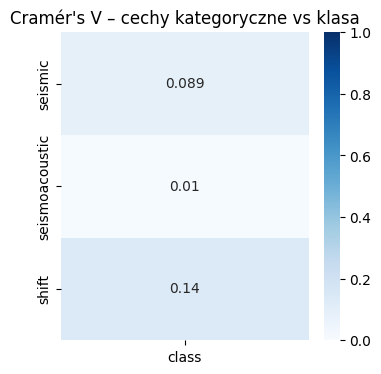

In [19]:
cat_cols = ['seismic', 'seismoacoustic', 'shift']

cramers_matrix = pd.DataFrame(
    [cramers_v(df[c], df['class']) for c in cat_cols],
    index=cat_cols,
    columns=['class']
)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cramers_matrix,
    annot=True,
    cmap='Blues',
    vmin=0, vmax=1,
    cbar=True
)
plt.title("Cramér's V – cechy kategoryczne vs klasa")
plt.show()

### Preprocesing i stworzenie treningowego SMOT

In [20]:
ordinal_cols = ['seismic', 'seismoacoustic', 'shift', 'ghazard']

encoder = OrdinalEncoder()
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

In [21]:
num_cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy']

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols].values)

In [22]:
X = df.drop('class', axis=1)  # zamień na swoją kolumnę celu
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

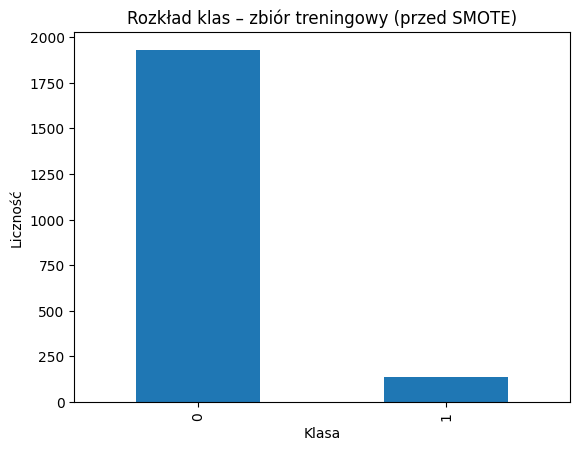

In [23]:
before_counts = y_train.value_counts().sort_index()

plt.figure()
before_counts.plot(kind='bar')
plt.title("Rozkład klas – zbiór treningowy (przed SMOTE)")
plt.xlabel("Klasa")
plt.ylabel("Liczność")
plt.show()

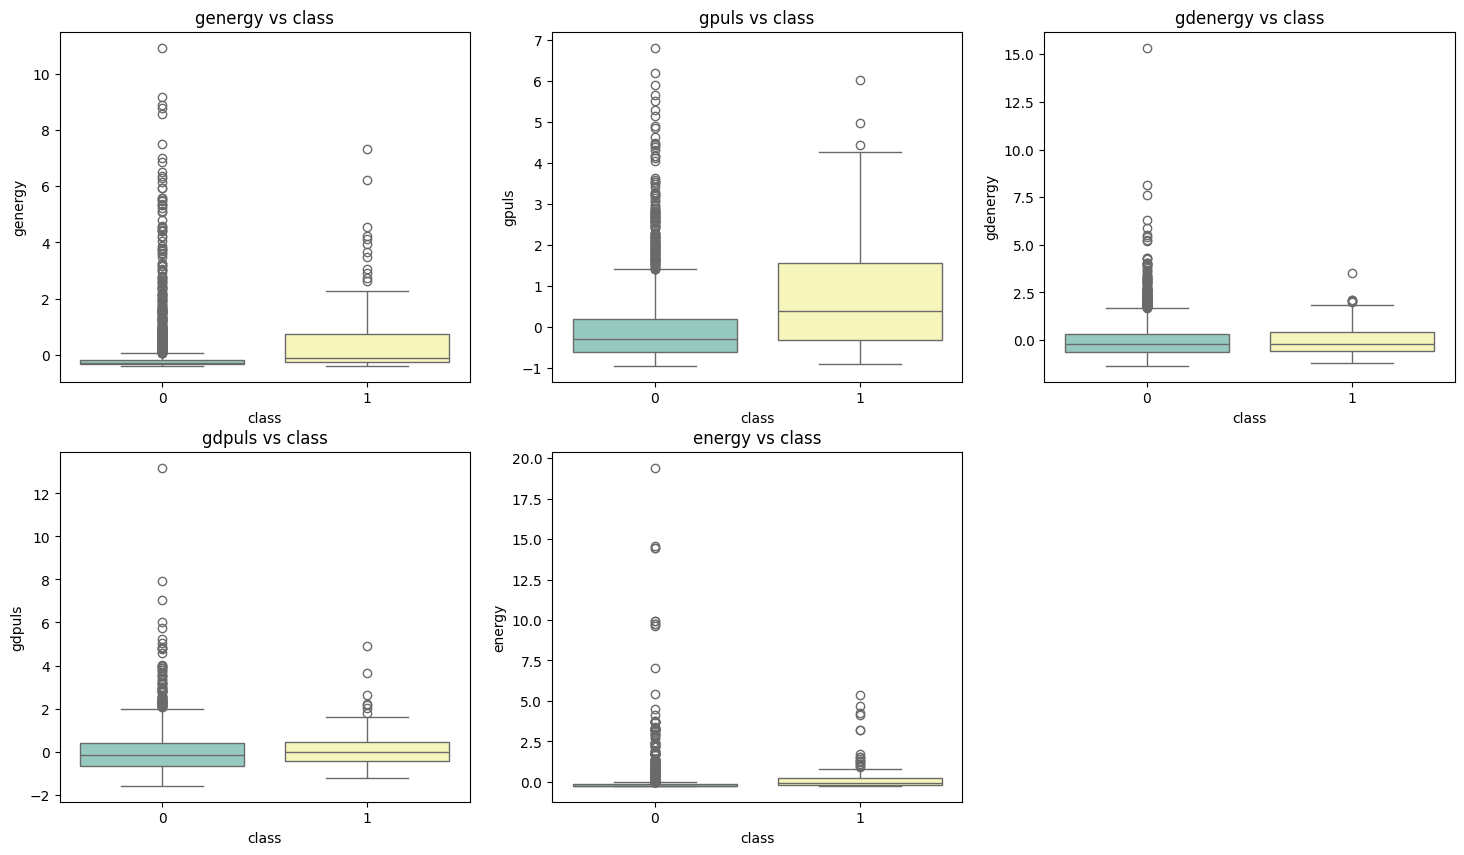

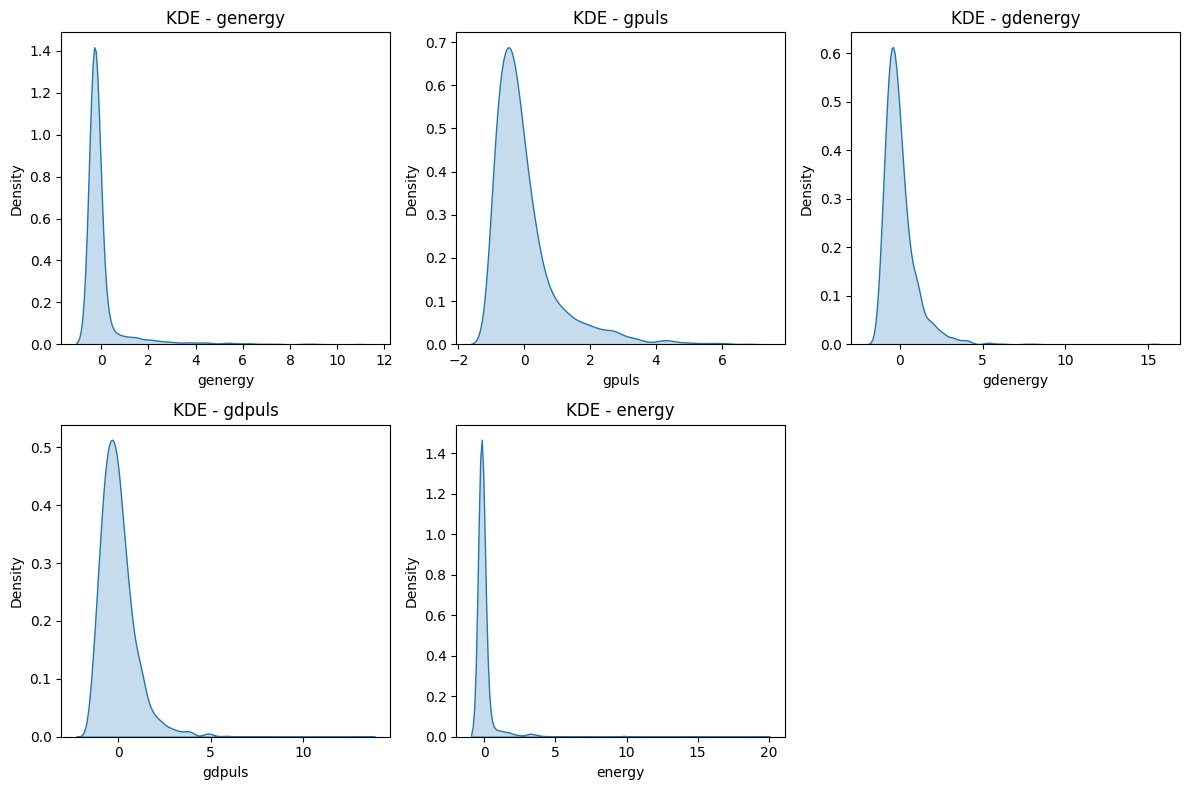

In [24]:
num_cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy']

plt.figure(figsize=(18, 10)) 
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=y_train, y=col, hue=y_train, data=X_train, palette="Set3", legend=False)
    plt.title(f"{col} vs class")
    plt.xlabel("class")
    plt.ylabel(col)
plt.show()

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=X_train, x=col, ax=axes[i], fill=True)
    axes[i].set_title(f"KDE - {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [25]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

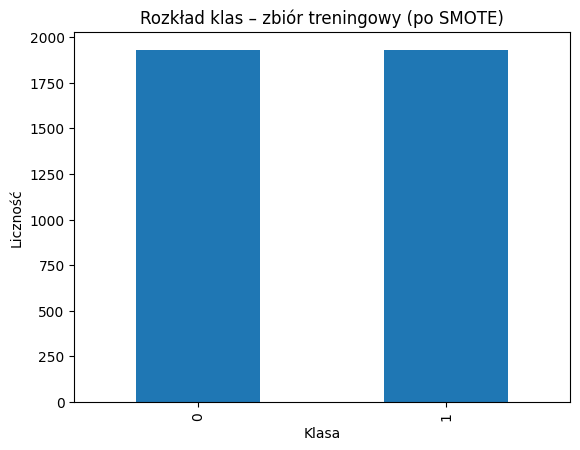

In [26]:
after_counts = y_train_smote.value_counts().sort_index()

plt.figure()
after_counts.plot(kind='bar')
plt.title("Rozkład klas – zbiór treningowy (po SMOTE)")
plt.xlabel("Klasa")
plt.ylabel("Liczność")
plt.show()

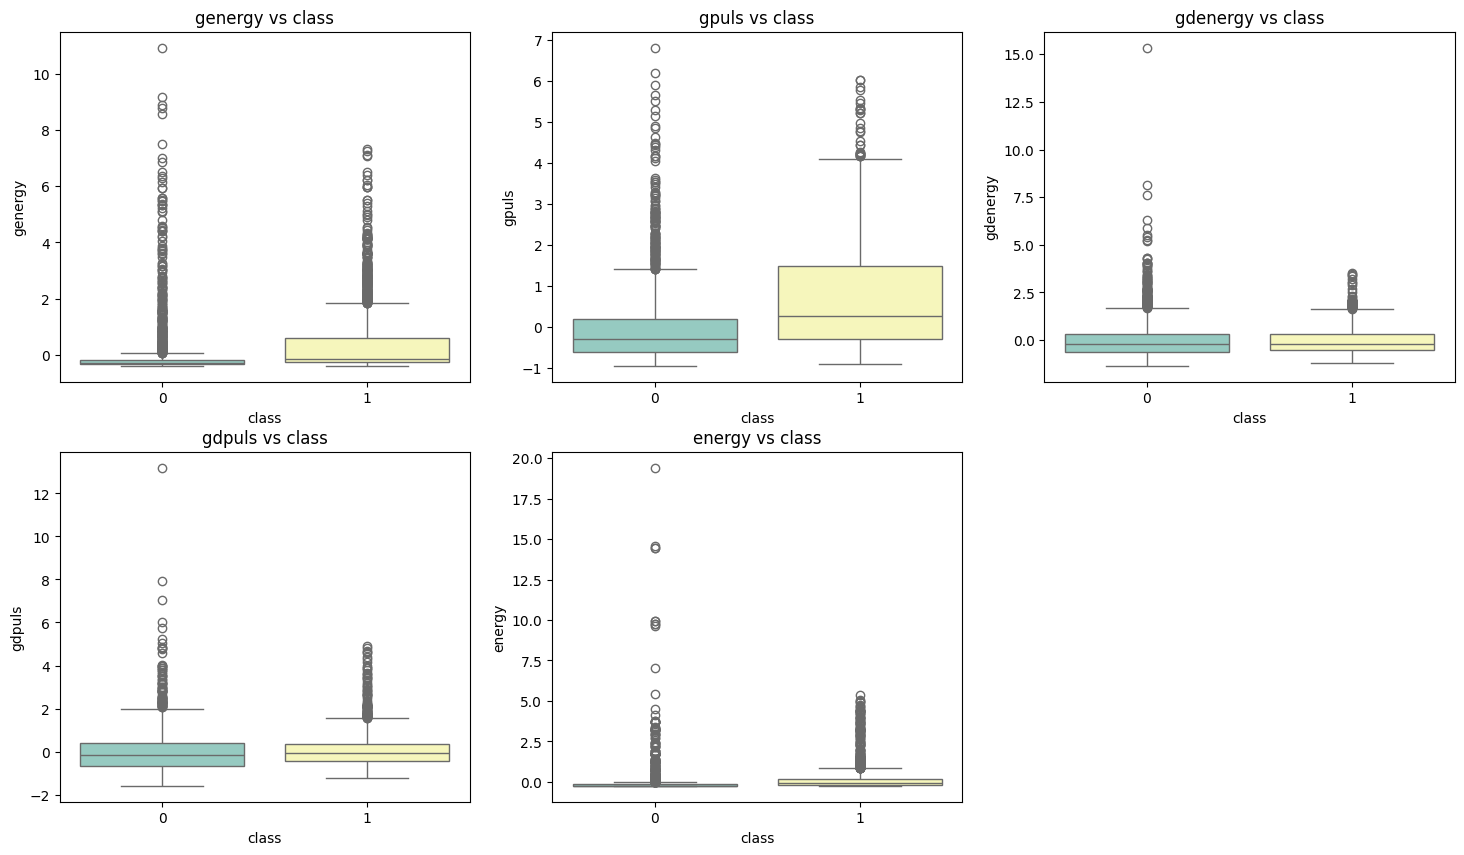

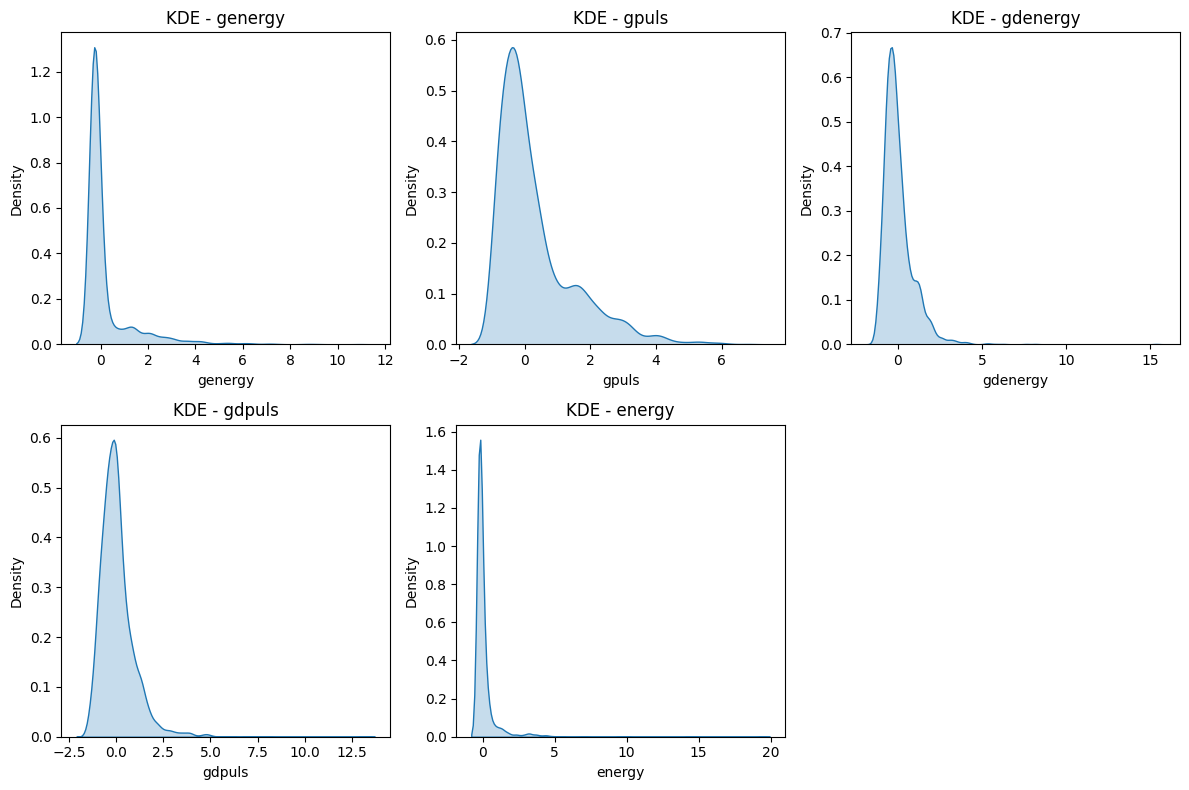

In [27]:
num_cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy']

plt.figure(figsize=(18, 10)) 
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=y_train_smote, y=col, hue=y_train_smote, data=X_train_smote, palette="Set3", legend=False)
    plt.title(f"{col} vs class")
    plt.xlabel("class")
    plt.ylabel(col)
plt.show()

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=X_train_smote, x=col, ax=axes[i], fill=True)
    axes[i].set_title(f"KDE - {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

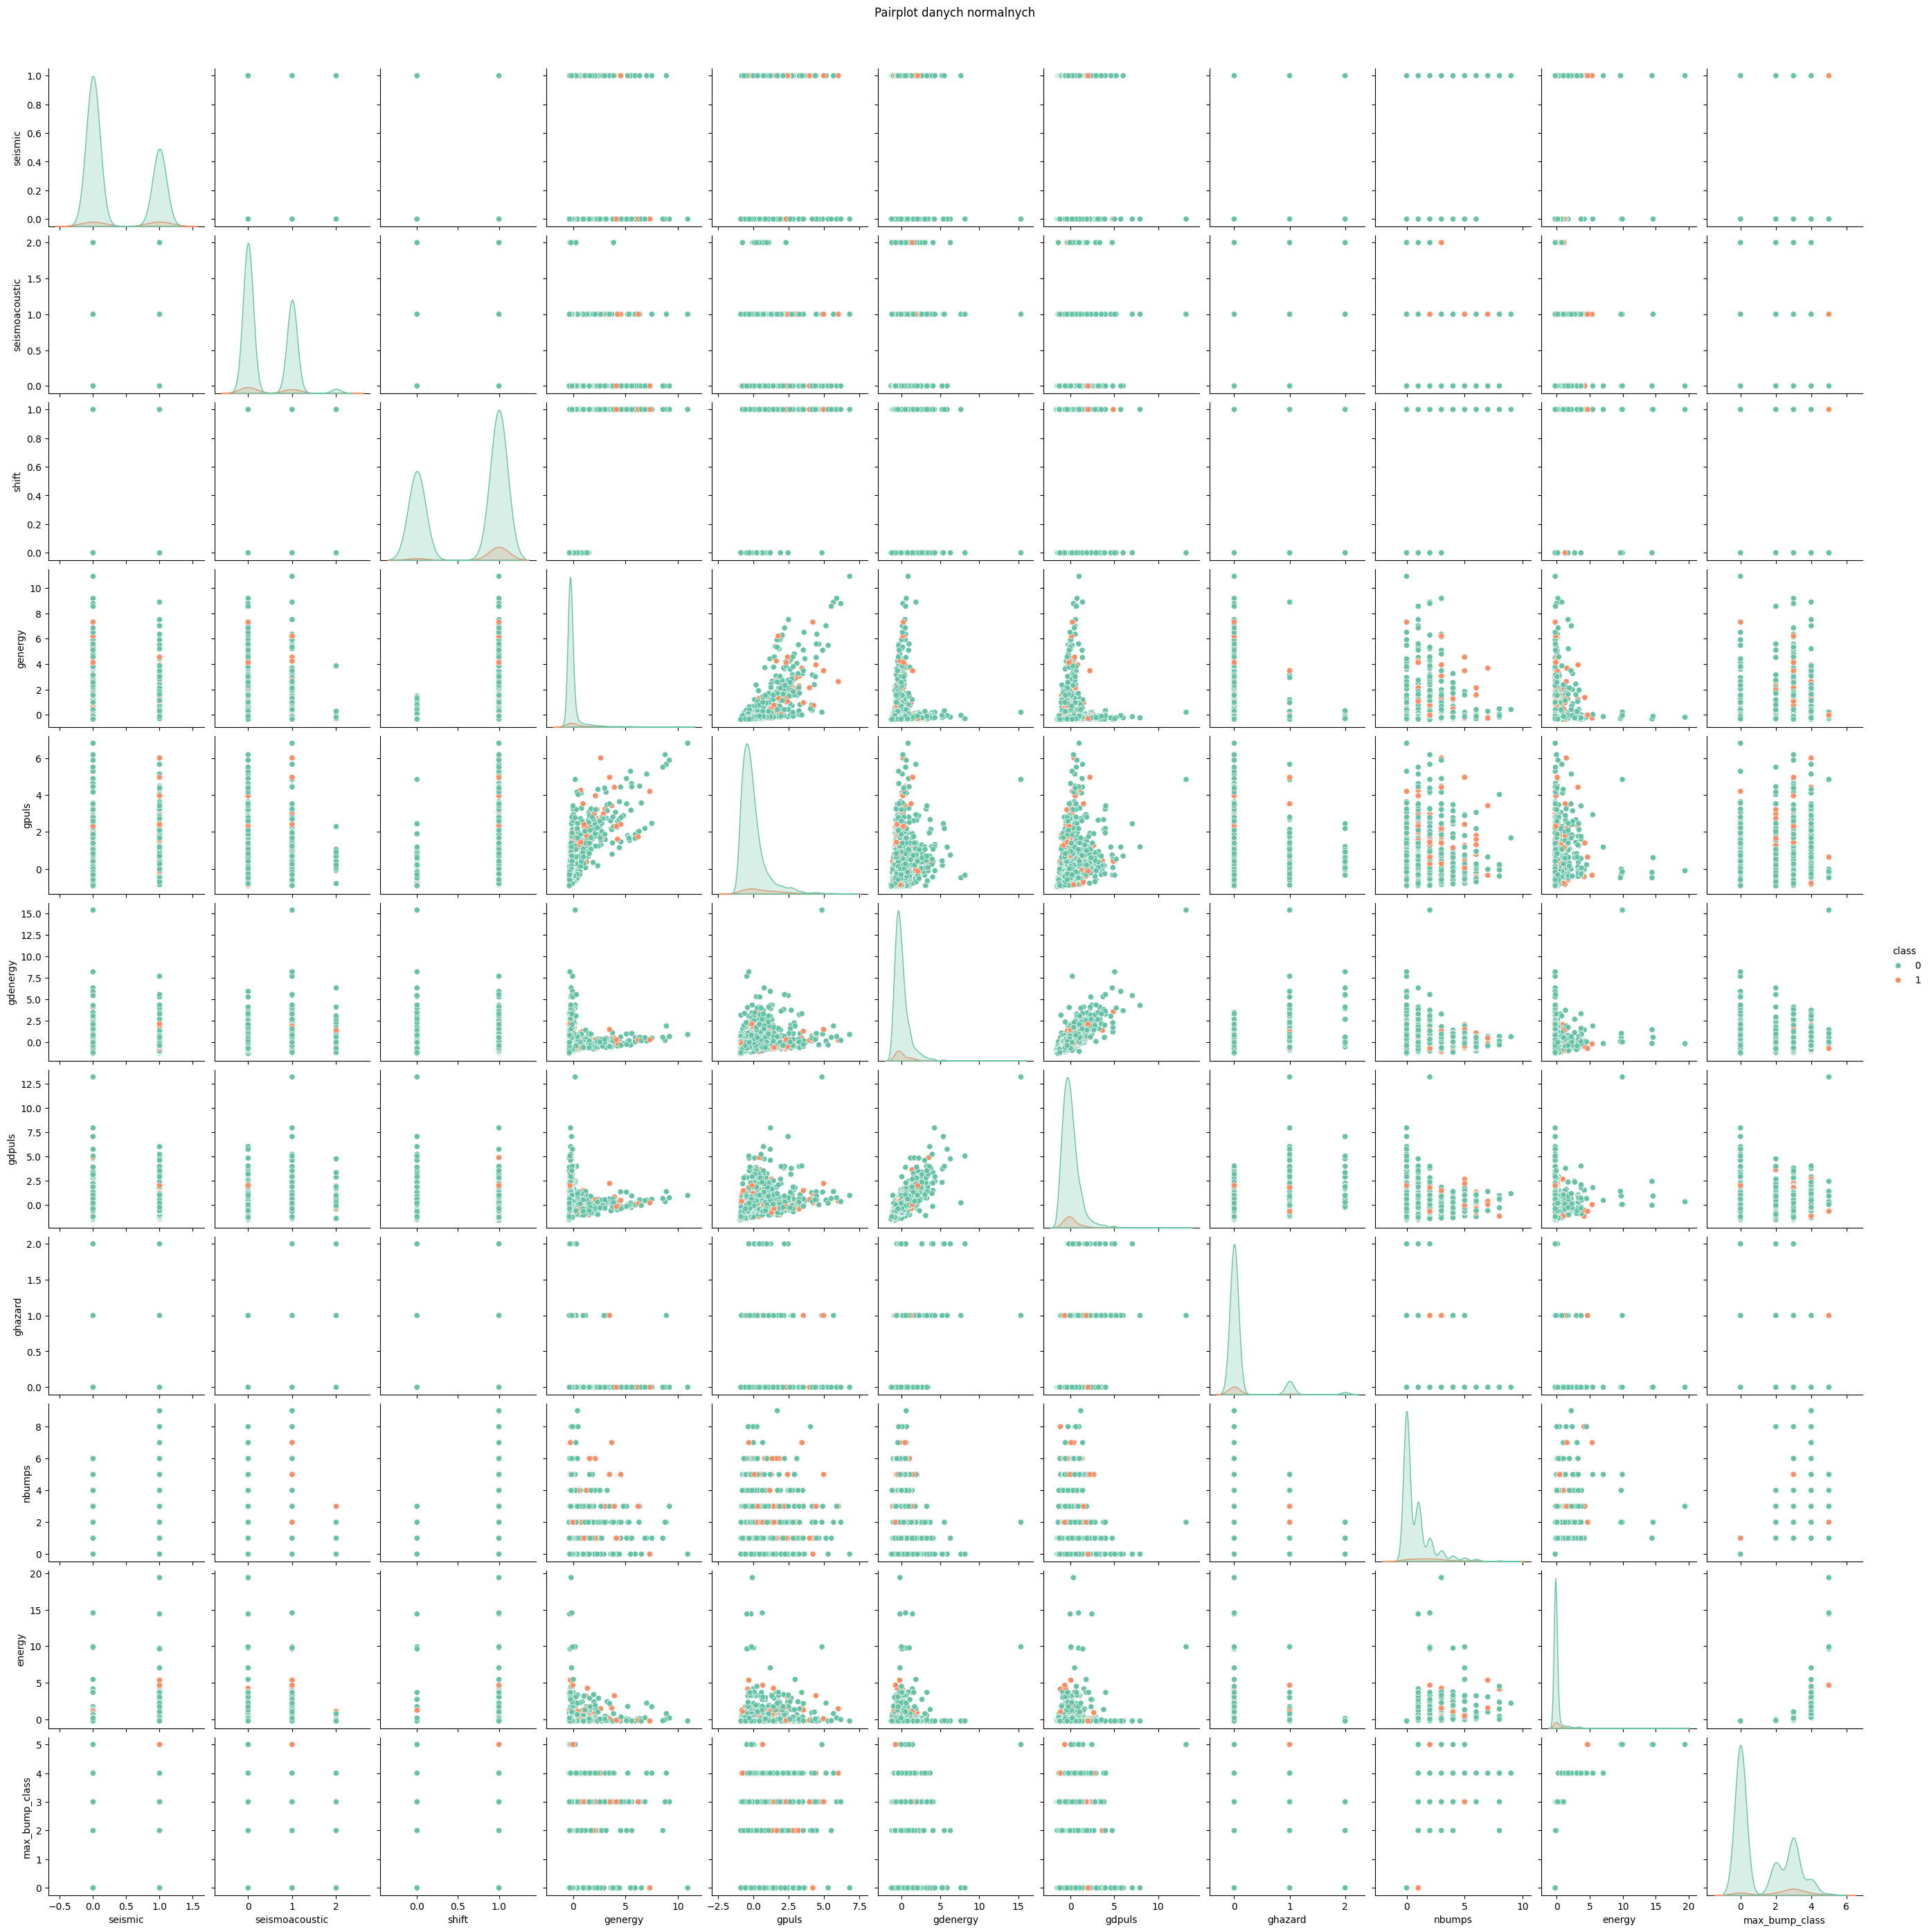

In [28]:
df_plot = X_train.copy()
df_plot['class'] = y_train  # dodajemy kolumnę z etykietami

sns.pairplot(df_plot, hue='class', palette='Set2', diag_kind='kde')
plt.suptitle("Pairplot danych normalnych", y=1.02)
plt.show()

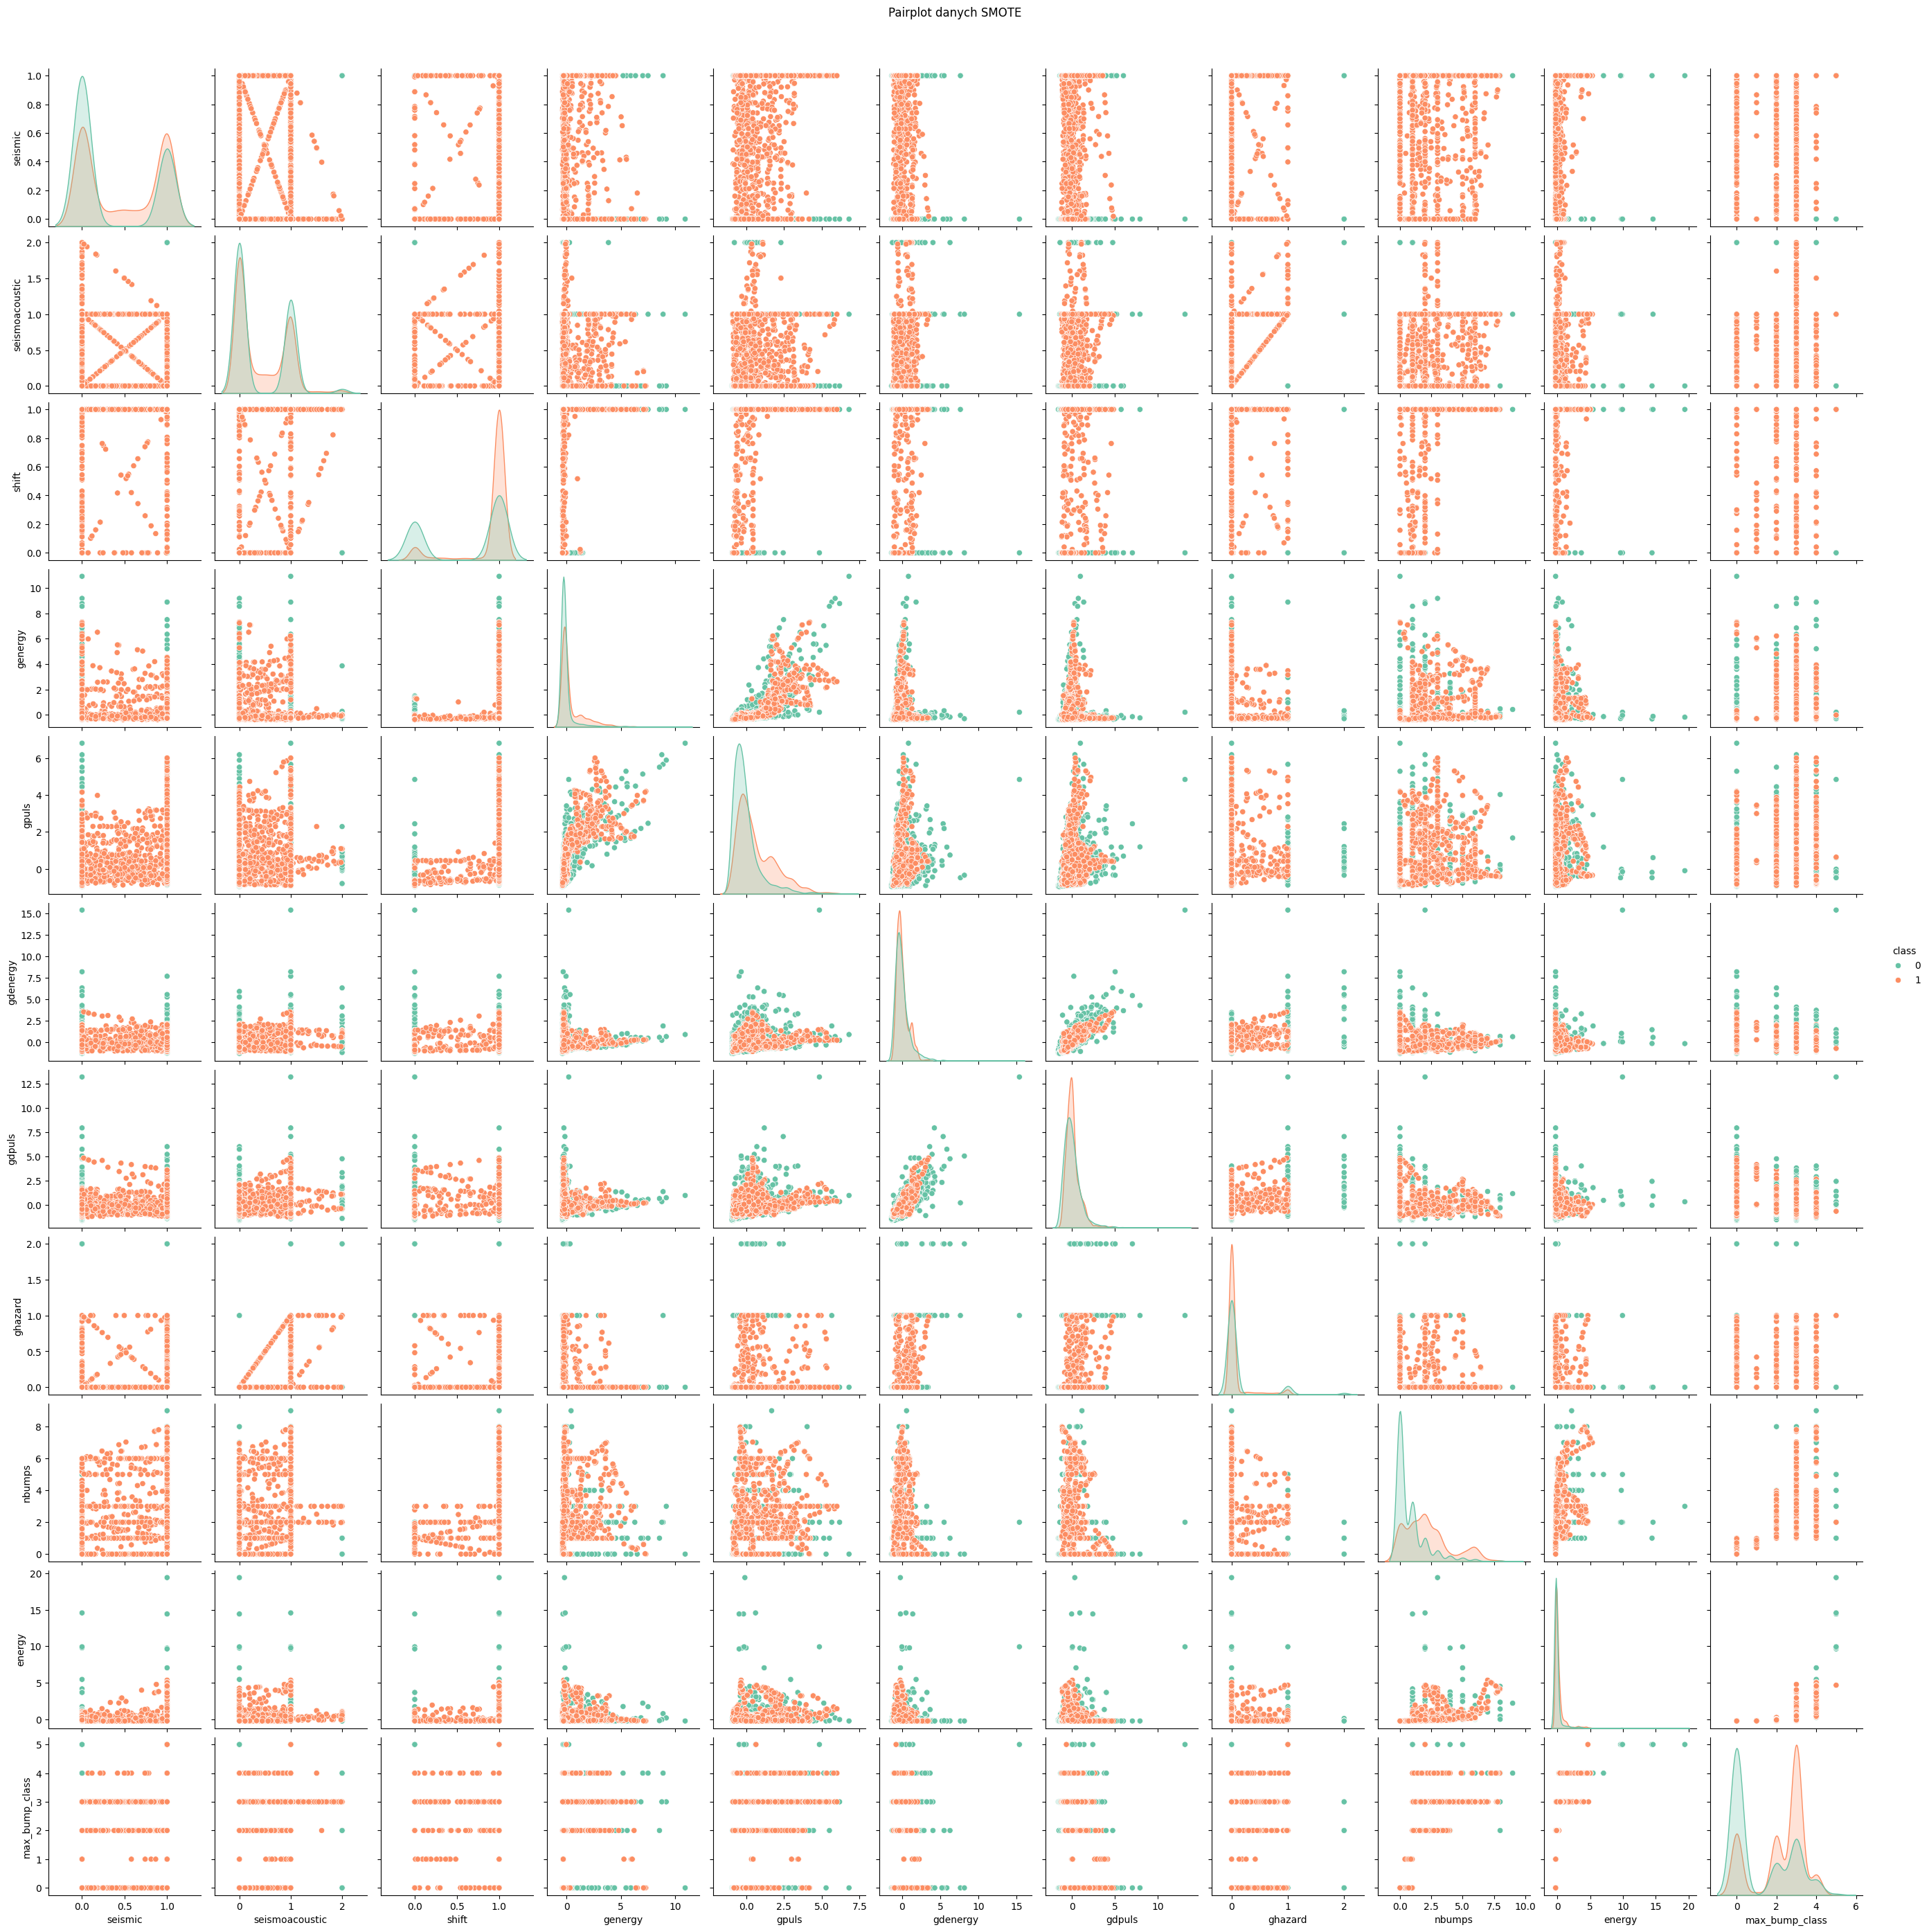

In [29]:
df_plot = X_train_smote.copy()
df_plot['class'] = y_train_smote  # dodajemy kolumnę z etykietami

sns.pairplot(df_plot, hue='class', palette='Set2', diag_kind='kde')
plt.suptitle("Pairplot danych SMOTE", y=1.02)
plt.show()

Widzimy że SMOTE nieco wpłynął na rozkłady cech

### KNN

In [30]:
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
k_values = range(3, 20,2)

In [31]:
results = []

for metric in metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            'k': k,
            'metric': metric,
            'accuracy': acc,
            'y_pred': y_pred  # zachowujemy predykcje dla późniejszej oceny
        })
        print(f"{metric} dla {k} gotowe")

df_results = pd.DataFrame(results)

euclidean dla 3 gotowe
euclidean dla 5 gotowe
euclidean dla 7 gotowe
euclidean dla 9 gotowe
euclidean dla 11 gotowe
euclidean dla 13 gotowe
euclidean dla 15 gotowe
euclidean dla 17 gotowe
euclidean dla 19 gotowe
manhattan dla 3 gotowe
manhattan dla 5 gotowe
manhattan dla 7 gotowe
manhattan dla 9 gotowe
manhattan dla 11 gotowe
manhattan dla 13 gotowe
manhattan dla 15 gotowe
manhattan dla 17 gotowe
manhattan dla 19 gotowe
chebyshev dla 3 gotowe
chebyshev dla 5 gotowe
chebyshev dla 7 gotowe
chebyshev dla 9 gotowe
chebyshev dla 11 gotowe
chebyshev dla 13 gotowe
chebyshev dla 15 gotowe
chebyshev dla 17 gotowe
chebyshev dla 19 gotowe
minkowski dla 3 gotowe
minkowski dla 5 gotowe
minkowski dla 7 gotowe
minkowski dla 9 gotowe
minkowski dla 11 gotowe
minkowski dla 13 gotowe
minkowski dla 15 gotowe
minkowski dla 17 gotowe
minkowski dla 19 gotowe


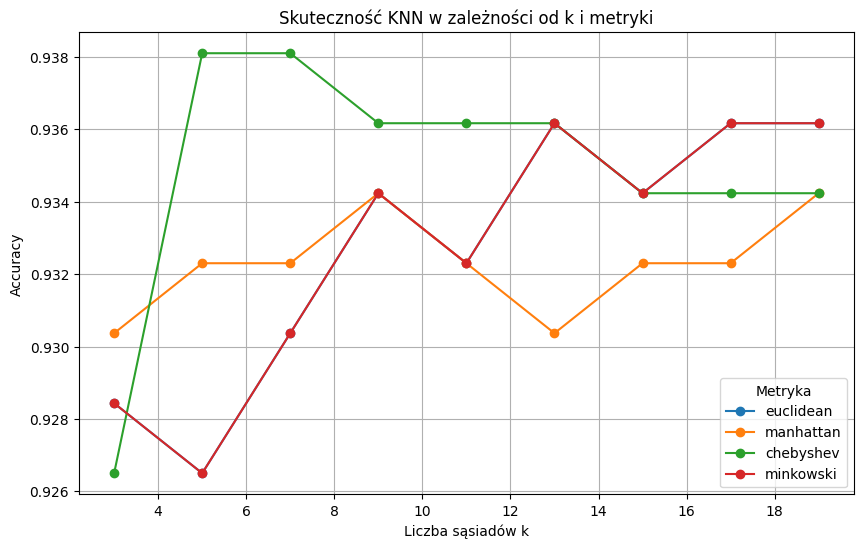

In [32]:
plt.figure(figsize=(10, 6))

for metric in df_results['metric'].unique():
    subset = df_results[df_results['metric'] == metric]
    plt.plot(
        subset['k'],
        subset['accuracy'],
        marker='o',
        label=metric
    )

plt.xlabel('Liczba sąsiadów k')
plt.ylabel('Accuracy')
plt.title('Skuteczność KNN w zależności od k i metryki')
plt.legend(title='Metryka')
plt.grid(True)
plt.show()

In [33]:
results = sorted(results, key=lambda x: x['accuracy'], reverse=True)
best_result = results[:5]
print("Top 5 wyników KNN:")
for res in best_result:
    print(f"k: {res['k']}, metric: {res['metric']}, accuracy: {res['accuracy']:.4f}, precision: {classification_report(y_test, res['y_pred'], output_dict=True)['weighted avg']['precision']:.4f}, recall: {classification_report(y_test, res['y_pred'], output_dict=True)['weighted avg']['recall']:.4f}, f1-score: {classification_report(y_test, res['y_pred'], output_dict=True)['weighted avg']['f1-score']:.4f}]")

Top 5 wyników KNN:
k: 5, metric: chebyshev, accuracy: 0.9381, precision: 0.9420, recall: 0.9381, f1-score: 0.9116]
k: 7, metric: chebyshev, accuracy: 0.9381, precision: 0.9420, recall: 0.9381, f1-score: 0.9116]
k: 13, metric: euclidean, accuracy: 0.9362, precision: 0.9403, recall: 0.9362, f1-score: 0.9071]
k: 17, metric: euclidean, accuracy: 0.9362, precision: 0.9403, recall: 0.9362, f1-score: 0.9071]
k: 19, metric: euclidean, accuracy: 0.9362, precision: 0.9403, recall: 0.9362, f1-score: 0.9071]


In [34]:
results = []

for metric in metrics:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_smote, y_train_smote)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            'k': k,
            'metric': metric,
            'accuracy': acc,
            'y_pred': y_pred  # zachowujemy predykcje dla późniejszej oceny
        })
        print(f"{metric} dla {k} gotowe")

df_results = pd.DataFrame(results)

euclidean dla 3 gotowe
euclidean dla 5 gotowe
euclidean dla 7 gotowe
euclidean dla 9 gotowe
euclidean dla 11 gotowe
euclidean dla 13 gotowe
euclidean dla 15 gotowe
euclidean dla 17 gotowe
euclidean dla 19 gotowe
manhattan dla 3 gotowe
manhattan dla 5 gotowe
manhattan dla 7 gotowe
manhattan dla 9 gotowe
manhattan dla 11 gotowe
manhattan dla 13 gotowe
manhattan dla 15 gotowe
manhattan dla 17 gotowe
manhattan dla 19 gotowe
chebyshev dla 3 gotowe
chebyshev dla 5 gotowe
chebyshev dla 7 gotowe
chebyshev dla 9 gotowe
chebyshev dla 11 gotowe
chebyshev dla 13 gotowe
chebyshev dla 15 gotowe
chebyshev dla 17 gotowe
chebyshev dla 19 gotowe
minkowski dla 3 gotowe
minkowski dla 5 gotowe
minkowski dla 7 gotowe
minkowski dla 9 gotowe
minkowski dla 11 gotowe
minkowski dla 13 gotowe
minkowski dla 15 gotowe
minkowski dla 17 gotowe
minkowski dla 19 gotowe


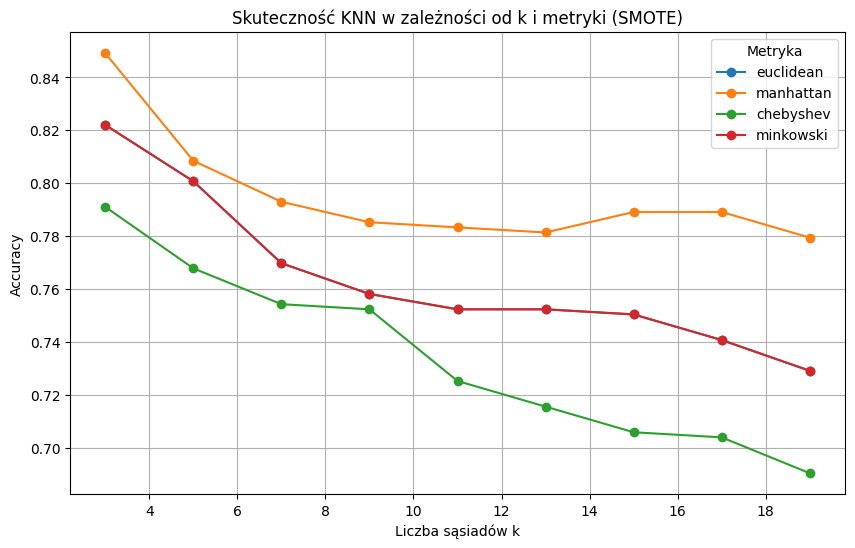

In [35]:
plt.figure(figsize=(10, 6))

for metric in df_results['metric'].unique():
    subset = df_results[df_results['metric'] == metric]
    plt.plot(
        subset['k'],
        subset['accuracy'],
        marker='o',
        label=metric
    )

plt.xlabel('Liczba sąsiadów k')
plt.ylabel('Accuracy')
plt.title('Skuteczność KNN w zależności od k i metryki (SMOTE)')
plt.legend(title='Metryka')
plt.grid(True)
plt.show()

In [36]:
results = sorted(results, key=lambda x: x['accuracy'], reverse=True)
best_result = results[:5]
print("Top 5 wyników KNN:")
for res in best_result:
    print(f"k: {res['k']}, metric: {res['metric']}, accuracy: {res['accuracy']:.4f}, precision: {classification_report(y_test, res['y_pred'], output_dict=True)['weighted avg']['precision']:.4f}, recall: {classification_report(y_test, res['y_pred'], output_dict=True)['weighted avg']['recall']:.4f}, f1-score: {classification_report(y_test, res['y_pred'], output_dict=True)['weighted avg']['f1-score']:.4f}]")

Top 5 wyników KNN:
k: 3, metric: manhattan, accuracy: 0.8491, precision: 0.9026, recall: 0.8491, f1-score: 0.8723]
k: 3, metric: euclidean, accuracy: 0.8221, precision: 0.9016, recall: 0.8221, f1-score: 0.8555]
k: 3, metric: minkowski, accuracy: 0.8221, precision: 0.9016, recall: 0.8221, f1-score: 0.8555]
k: 5, metric: manhattan, accuracy: 0.8085, precision: 0.8951, recall: 0.8085, f1-score: 0.8455]
k: 5, metric: euclidean, accuracy: 0.8008, precision: 0.9067, recall: 0.8008, f1-score: 0.8433]


### Bayes Inference

In [37]:
mean = X_train.describe().loc['mean'].values
var_factors = [0.25, 0.5, 1.0, 2.0, 4.0]
priors_list = [[0.9, 0.1], [0.8, 0.2], [0.7, 0.3], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.3, 0.7], [0.2, 0.8], [0.1, 0.9]]

results = []

for vs in var_factors:
    for pr in priors_list:
        gnb = GaussianNB(priors=pr)
        gnb.fit(X_train, y_train)
        gnb.var_= gnb.var_ * vs * mean  # skalowanie wariancji
        y_pred = gnb.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            'variance_scaler': vs,
            'priors': pr,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

results_df = pd.DataFrame(results)

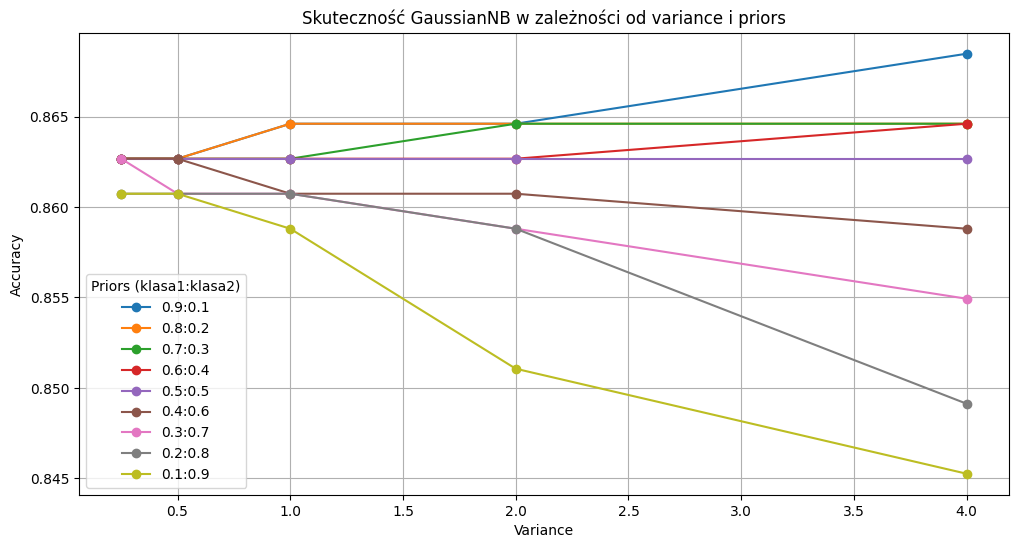

In [38]:

plt.figure(figsize=(12, 6))


results_df['priors_str'] = results_df['priors'].apply(lambda x: f"{x[0]}:{x[1]}")

for pr_str in results_df['priors_str'].unique():
    subset = results_df[results_df['priors_str'] == pr_str]
    plt.plot(
        subset['variance_scaler'],
        subset['accuracy'],
        marker='o',
        label=pr_str
    )

plt.xlabel('Variance')
plt.ylabel('Accuracy')
plt.title('Skuteczność GaussianNB w zależności od variance i priors')
plt.legend(title='Priors (klasa1:klasa2)')
plt.grid(True)
plt.show()

In [39]:
results_df = results_df.sort_values(by='accuracy', ascending=False)
print("Top 5 wyników GaussianNB:")
for i, row in results_df.head(5).iterrows():
    print(f"Variance scaler: {row['variance_scaler']}, Priors: {row['priors']}, Accuracy: {row['accuracy']:.4f}, Precision: {row['precision']:.4f}, Recall: {row['recall']:.4f}, F1-score: {row['f1_score']:.4f}]")

Top 5 wyników GaussianNB:
Variance scaler: 4.0, Priors: [0.9, 0.1], Accuracy: 0.8685, Precision: 0.9031, Recall: 0.8685, F1-score: 0.8840]
Variance scaler: 1.0, Priors: [0.9, 0.1], Accuracy: 0.8646, Precision: 0.9024, Recall: 0.8646, F1-score: 0.8815]
Variance scaler: 2.0, Priors: [0.8, 0.2], Accuracy: 0.8646, Precision: 0.9024, Recall: 0.8646, F1-score: 0.8815]
Variance scaler: 1.0, Priors: [0.8, 0.2], Accuracy: 0.8646, Precision: 0.9024, Recall: 0.8646, F1-score: 0.8815]
Variance scaler: 4.0, Priors: [0.8, 0.2], Accuracy: 0.8646, Precision: 0.9024, Recall: 0.8646, F1-score: 0.8815]


In [40]:
mean = X_train_smote.describe().loc['mean'].values
var_factors = [0.25, 0.5, 1.0, 2.0, 4.0]
priors_list = [[0.9, 0.1], [0.8, 0.2], [0.7, 0.3], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.3, 0.7], [0.2, 0.8], [0.1, 0.9]]

results = []

for vs in var_factors:
    for pr in priors_list:
        gnb = GaussianNB(priors=pr)
        gnb.fit(X_train_smote, y_train_smote)
        gnb.var_= gnb.var_ * vs * mean  # skalowanie wariancji
        y_pred = gnb.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            'variance_scaler': vs,
            'priors': pr,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

results_df = pd.DataFrame(results)

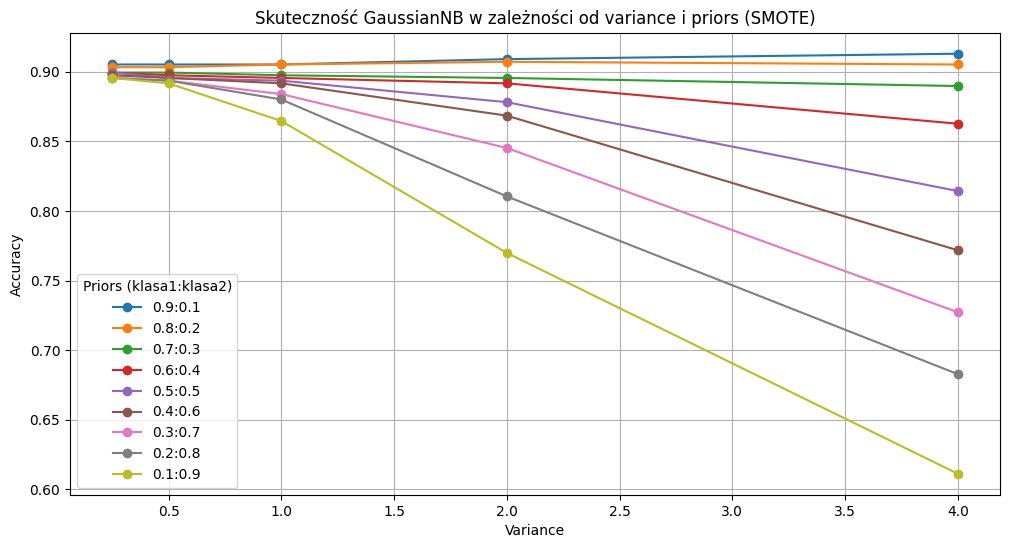

In [41]:

plt.figure(figsize=(12, 6))


results_df['priors_str'] = results_df['priors'].apply(lambda x: f"{x[0]}:{x[1]}")

for pr_str in results_df['priors_str'].unique():
    subset = results_df[results_df['priors_str'] == pr_str]
    plt.plot(
        subset['variance_scaler'],
        subset['accuracy'],
        marker='o',
        label=pr_str
    )

plt.xlabel('Variance')
plt.ylabel('Accuracy')
plt.title('Skuteczność GaussianNB w zależności od variance i priors (SMOTE)')
plt.legend(title='Priors (klasa1:klasa2)')
plt.grid(True)
plt.show()

In [42]:
results_df = results_df.sort_values(by='accuracy', ascending=False)
print("Top 5 wyników GaussianNB:")
for i, row in results_df.head(5).iterrows():
    print(f"Variance scaler: {row['variance_scaler']}, Priors: {row['priors']}, Accuracy: {row['accuracy']:.4f}, Precision: {row['precision']:.4f}, Recall: {row['recall']:.4f}, F1-score: {row['f1_score']:.4f}]")

Top 5 wyników GaussianNB:
Variance scaler: 4.0, Priors: [0.9, 0.1], Accuracy: 0.9130, Precision: 0.9014, Recall: 0.9130, F1-score: 0.9067]
Variance scaler: 2.0, Priors: [0.9, 0.1], Accuracy: 0.9091, Precision: 0.8998, Recall: 0.9091, F1-score: 0.9042]
Variance scaler: 2.0, Priors: [0.8, 0.2], Accuracy: 0.9072, Precision: 0.9019, Recall: 0.9072, F1-score: 0.9044]
Variance scaler: 0.5, Priors: [0.9, 0.1], Accuracy: 0.9052, Precision: 0.8984, Recall: 0.9052, F1-score: 0.9017]
Variance scaler: 0.25, Priors: [0.9, 0.1], Accuracy: 0.9052, Precision: 0.8984, Recall: 0.9052, F1-score: 0.9017]


### SVM

In [43]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10]
gamma_values = ['scale', 0.01, 0.1]

In [45]:
results_svm = []

for kernel in kernels:
    for C in C_values:
        for gamma in gamma_values:
            if kernel == 'linear' and gamma != 'scale':
                continue
            svm = SVC(kernel=kernel, C=C, gamma=gamma)
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            results_svm.append({
                'kernel': kernel,
                'C': C,
                'gamma': gamma,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })
            print(f"SVM {kernel} C={C} gamma={gamma} gotowe")

results_svm_df = pd.DataFrame(results_svm)
results_svm_df = results_svm_df.sort_values('f1_score', ascending=False)


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

SVM linear C=0.1 gamma=scale gotowe
SVM linear C=1 gamma=scale gotowe
SVM linear C=10 gamma=scale gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM poly C=0.1 gamma=scale gotowe
SVM poly C=0.1 gamma=0.01 gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM poly C=0.1 gamma=0.1 gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM poly C=1 gamma=scale gotowe
SVM poly C=1 gamma=0.01 gotowe
SVM poly C=1 gamma=0.1 gotowe
SVM poly C=10 gamma=scale gotowe
SVM poly C=10 gamma=0.01 gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM poly C=10 gamma=0.1 gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM rbf C=0.1 gamma=scale gotowe
SVM rbf C=0.1 gamma=0.01 gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM rbf C=0.1 gamma=0.1 gotowe
SVM rbf C=1 gamma=scale gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM rbf C=1 gamma=0.01 gotowe
SVM rbf C=1 gamma=0.1 gotowe
SVM rbf C=10 gamma=scale gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM rbf C=10 gamma=0.01 gotowe
SVM rbf C=10 gamma=0.1 gotowe
SVM sigmoid C=0.1 gamma=scale gotowe
SVM sigmoid C=0.1 gamma=0.01 gotowe
SVM sigmoid C=0.1 gamma=0.1 gotowe


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


SVM sigmoid C=1 gamma=scale gotowe
SVM sigmoid C=1 gamma=0.01 gotowe
SVM sigmoid C=1 gamma=0.1 gotowe
SVM sigmoid C=10 gamma=scale gotowe
SVM sigmoid C=10 gamma=0.01 gotowe
SVM sigmoid C=10 gamma=0.1 gotowe


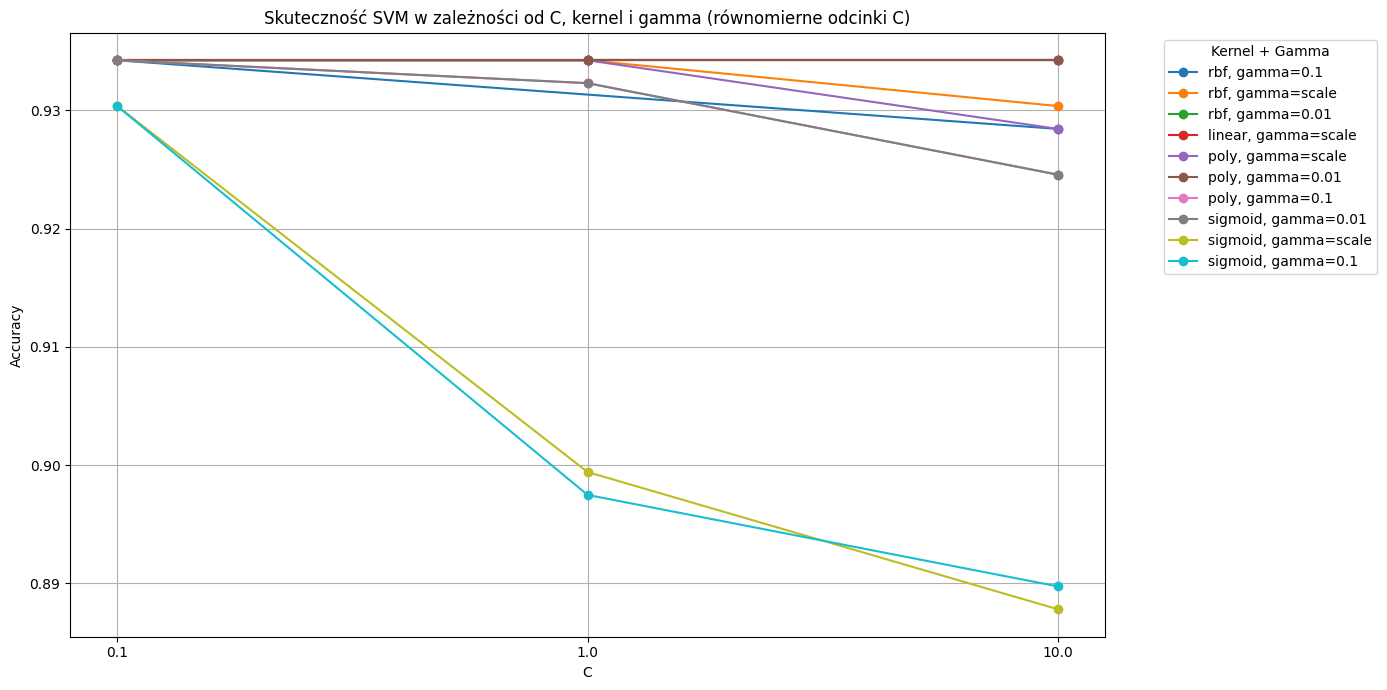

In [51]:
plt.figure(figsize=(14, 7))

C_unique = sorted(results_svm_df['C'].unique())
C_index = {c: i for i, c in enumerate(C_unique)}

for kernel in results_svm_df['kernel'].unique():
    subset_kernel = results_svm_df[results_svm_df['kernel'] == kernel]
    for gamma in subset_kernel['gamma'].unique():
        subset = subset_kernel[subset_kernel['gamma'] == gamma]
        x_positions = [C_index[c] for c in subset['C']]
        plt.plot(
            x_positions,
            subset['accuracy'],
            marker='o',
            label=f"{kernel}, gamma={gamma}"
        )

plt.xticks(range(len(C_unique)), C_unique)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Skuteczność SVM w zależności od C, kernel i gamma (równomierne odcinki C)')
plt.legend(title='Kernel + Gamma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
results_svm = sorted(results_svm, key=lambda x: x['accuracy'], reverse=True)
print("Top 5 wyników SVM:")
for res in results_svm[:5]:
    print(f"Kernel: {res['kernel']}, C: {res['C']}, Gamma: {res['gamma']}, Accuracy: {res['accuracy']:.4f}, Precision: {res['precision']:.4f}, Recall: {res['recall']:.4f}, F1-score: {res['f1_score']:.4f}]")

Top 5 wyników SVM:
Kernel: linear, C: 0.1, Gamma: scale, Accuracy: 0.9342, Precision: 0.8728, Recall: 0.9342, F1-score: 0.9025]
Kernel: linear, C: 1, Gamma: scale, Accuracy: 0.9342, Precision: 0.8728, Recall: 0.9342, F1-score: 0.9025]
Kernel: linear, C: 10, Gamma: scale, Accuracy: 0.9342, Precision: 0.8728, Recall: 0.9342, F1-score: 0.9025]
Kernel: poly, C: 0.1, Gamma: scale, Accuracy: 0.9342, Precision: 0.8728, Recall: 0.9342, F1-score: 0.9025]
Kernel: poly, C: 0.1, Gamma: 0.01, Accuracy: 0.9342, Precision: 0.8728, Recall: 0.9342, F1-score: 0.9025]


In [53]:
results_svm = []

for kernel in kernels:
    for C in C_values:
        for gamma in gamma_values:
            if kernel == 'linear' and gamma != 'scale':
                continue
            svm = SVC(kernel=kernel, C=C, gamma=gamma)
            svm.fit(X_train_smote, y_train_smote)
            y_pred = svm.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            results_svm.append({
                'kernel': kernel,
                'C': C,
                'gamma': gamma,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })
            print(f"SVM {kernel} C={C} gamma={gamma} gotowe")

results_svm_df = pd.DataFrame(results_svm)
results_svm_df = results_svm_df.sort_values('f1_score', ascending=False)

SVM linear C=0.1 gamma=scale gotowe
SVM linear C=1 gamma=scale gotowe
SVM linear C=10 gamma=scale gotowe
SVM poly C=0.1 gamma=scale gotowe
SVM poly C=0.1 gamma=0.01 gotowe
SVM poly C=0.1 gamma=0.1 gotowe
SVM poly C=1 gamma=scale gotowe
SVM poly C=1 gamma=0.01 gotowe
SVM poly C=1 gamma=0.1 gotowe
SVM poly C=10 gamma=scale gotowe
SVM poly C=10 gamma=0.01 gotowe
SVM poly C=10 gamma=0.1 gotowe
SVM rbf C=0.1 gamma=scale gotowe
SVM rbf C=0.1 gamma=0.01 gotowe
SVM rbf C=0.1 gamma=0.1 gotowe
SVM rbf C=1 gamma=scale gotowe
SVM rbf C=1 gamma=0.01 gotowe
SVM rbf C=1 gamma=0.1 gotowe
SVM rbf C=10 gamma=scale gotowe
SVM rbf C=10 gamma=0.01 gotowe
SVM rbf C=10 gamma=0.1 gotowe
SVM sigmoid C=0.1 gamma=scale gotowe
SVM sigmoid C=0.1 gamma=0.01 gotowe
SVM sigmoid C=0.1 gamma=0.1 gotowe
SVM sigmoid C=1 gamma=scale gotowe
SVM sigmoid C=1 gamma=0.01 gotowe
SVM sigmoid C=1 gamma=0.1 gotowe
SVM sigmoid C=10 gamma=scale gotowe
SVM sigmoid C=10 gamma=0.01 gotowe
SVM sigmoid C=10 gamma=0.1 gotowe


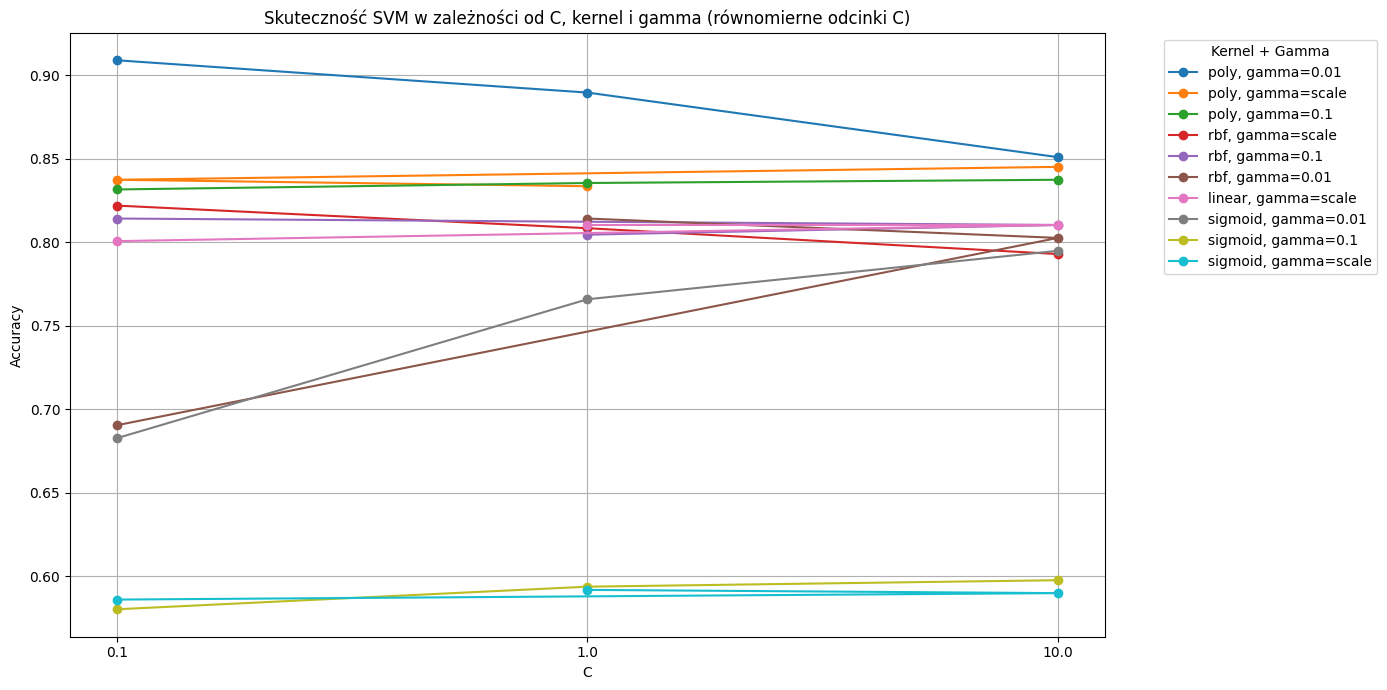

In [54]:
plt.figure(figsize=(14, 7))

C_unique = sorted(results_svm_df['C'].unique())
C_index = {c: i for i, c in enumerate(C_unique)}

for kernel in results_svm_df['kernel'].unique():
    subset_kernel = results_svm_df[results_svm_df['kernel'] == kernel]
    for gamma in subset_kernel['gamma'].unique():
        subset = subset_kernel[subset_kernel['gamma'] == gamma]
        x_positions = [C_index[c] for c in subset['C']]
        plt.plot(
            x_positions,
            subset['accuracy'],
            marker='o',
            label=f"{kernel}, gamma={gamma}"
        )

plt.xticks(range(len(C_unique)), C_unique)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Skuteczność SVM w zależności od C, kernel i gamma (równomierne odcinki C)')
plt.legend(title='Kernel + Gamma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
results_svm = sorted(results_svm, key=lambda x: x['accuracy'], reverse=True)
print("Top 5 wyników SVM:")
for res in results_svm[:5]:
    print(f"Kernel: {res['kernel']}, C: {res['C']}, Gamma: {res['gamma']}, Accuracy: {res['accuracy']:.4f}, Precision: {res['precision']:.4f}, Recall: {res['recall']:.4f}, F1-score: {res['f1_score']:.4f}]")

Top 5 wyników SVM:
Kernel: poly, C: 0.1, Gamma: 0.01, Accuracy: 0.9091, Precision: 0.8969, Recall: 0.9091, F1-score: 0.9026]
Kernel: poly, C: 1, Gamma: 0.01, Accuracy: 0.8897, Precision: 0.9170, Recall: 0.8897, F1-score: 0.9015]
Kernel: poly, C: 10, Gamma: 0.01, Accuracy: 0.8511, Precision: 0.9151, Recall: 0.8511, F1-score: 0.8771]
Kernel: poly, C: 10, Gamma: scale, Accuracy: 0.8453, Precision: 0.9094, Recall: 0.8453, F1-score: 0.8720]
Kernel: poly, C: 0.1, Gamma: scale, Accuracy: 0.8375, Precision: 0.9133, Recall: 0.8375, F1-score: 0.8681]


### Sieć neuronowa

In [57]:
from sklearn.neural_network import MLPClassifier

hidden_layer_options = [
    (10,),      # 1 warstwa, 10 neuronów
    (50,),      # 1 warstwa, 50 neuronów
    (50, 20),   # 2 warstwy: 50 + 20
    (100, 50),  # 2 warstwy: 100 + 50
    (100, 50, 20),  # 3 warstwy: 100 + 50 + 20
    (200, 100, 50),   # 3 warstwy: 200 + 100 + 50
    (300, 150, 75)    # 3 warstwy: 300 + 150 + 75

]

activation_functions = ['relu', 'tanh', 'logistic']
solvers = ['adam', 'sgd', 'lbfgs']

In [58]:
results_nn = []

for hidden_layers in hidden_layer_options:
    for activation in activation_functions:
        for solver in solvers:
            mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=activation, solver=solver, max_iter=500, random_state=42)
            mlp.fit(X_train, y_train)
            y_pred = mlp.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            results_nn.append({
                'hidden_layers': hidden_layers,
                'activation': activation,
                'solver': solver,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

results_nn_df = pd.DataFrame(results_nn)

C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:606: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined 

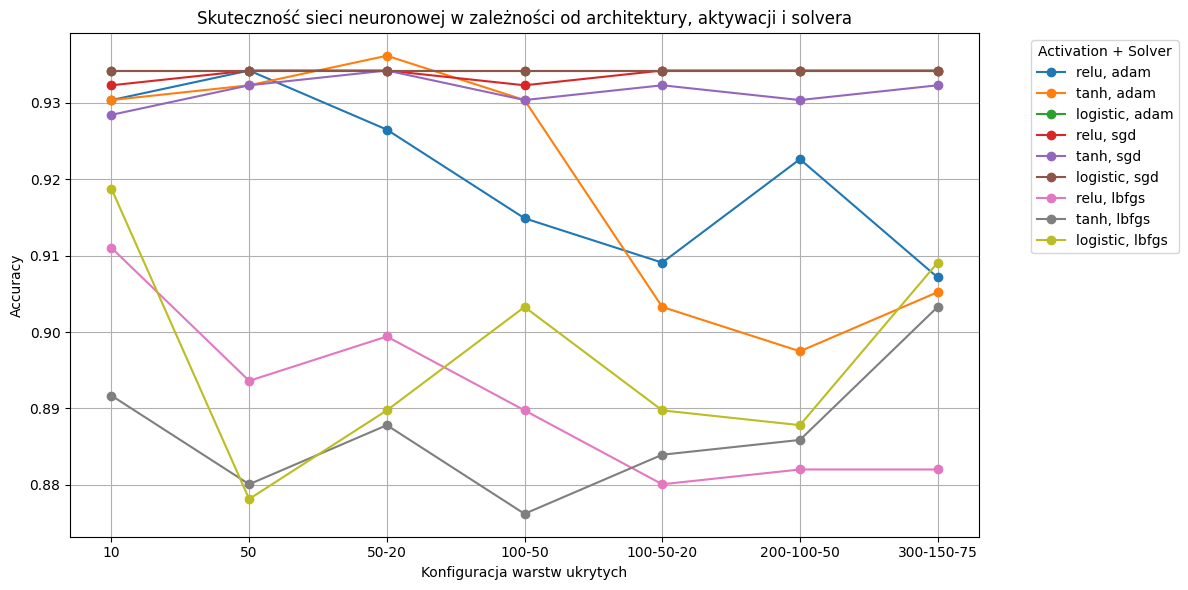

In [62]:
plt.figure(figsize=(12, 6))

results_nn_df['hidden_layers_str'] = results_nn_df['hidden_layers'].apply(lambda x: '-'.join(map(str, x)))

for solver in results_nn_df['solver'].unique():
    subset_solver = results_nn_df[results_nn_df['solver'] == solver]
    for activation in subset_solver['activation'].unique():
        subset = subset_solver[subset_solver['activation'] == activation]
        plt.plot(
            subset['hidden_layers_str'],
            subset['accuracy'],
            marker='o',
            label=f"{activation}, {solver}"
        )

plt.xlabel('Konfiguracja warstw ukrytych')
plt.ylabel('Accuracy')
plt.title('Skuteczność sieci neuronowej w zależności od architektury, aktywacji i solvera')
plt.legend(title='Activation + Solver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
results_nn_df = results_nn_df.sort_values('accuracy', ascending=False)
print("Top 5 wyników sieci neuronowej:")
for i, row in results_nn_df.head(5).iterrows():
    print(f"Hidden layers: {row['hidden_layers']}, Activation: {row['activation']}, Solver: {row['solver']}, Accuracy: {row['accuracy']:.4f}, Precision: {row['precision']:.4f}, Recall: {row['recall']:.4f}, F1-score: {row['f1_score']:.4f}]")

Top 5 wyników sieci neuronowej:
Hidden layers: (50, 20), Activation: tanh, Solver: adam, Accuracy: 0.9362, Precision: 0.9169, Recall: 0.9362, F1-score: 0.9160]
Hidden layers: (50,), Activation: relu, Solver: adam, Accuracy: 0.9342, Precision: 0.9073, Recall: 0.9342, F1-score: 0.9061]
Hidden layers: (10,), Activation: logistic, Solver: adam, Accuracy: 0.9342, Precision: 0.8728, Recall: 0.9342, F1-score: 0.9025]
Hidden layers: (50,), Activation: relu, Solver: sgd, Accuracy: 0.9342, Precision: 0.9073, Recall: 0.9342, F1-score: 0.9061]
Hidden layers: (50, 20), Activation: relu, Solver: sgd, Accuracy: 0.9342, Precision: 0.8728, Recall: 0.9342, F1-score: 0.9025]


In [65]:
results_nn = []

for hidden_layers in hidden_layer_options:
    for activation in activation_functions:
        for solver in solvers:
            mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=activation, solver=solver, max_iter=500, random_state=42)
            mlp.fit(X_train_smote, y_train_smote)
            y_pred = mlp.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            results_nn.append({
                'hidden_layers': hidden_layers,
                'activation': activation,
                'solver': solver,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

results_nn_df = pd.DataFrame(results_nn)

C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:606: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings

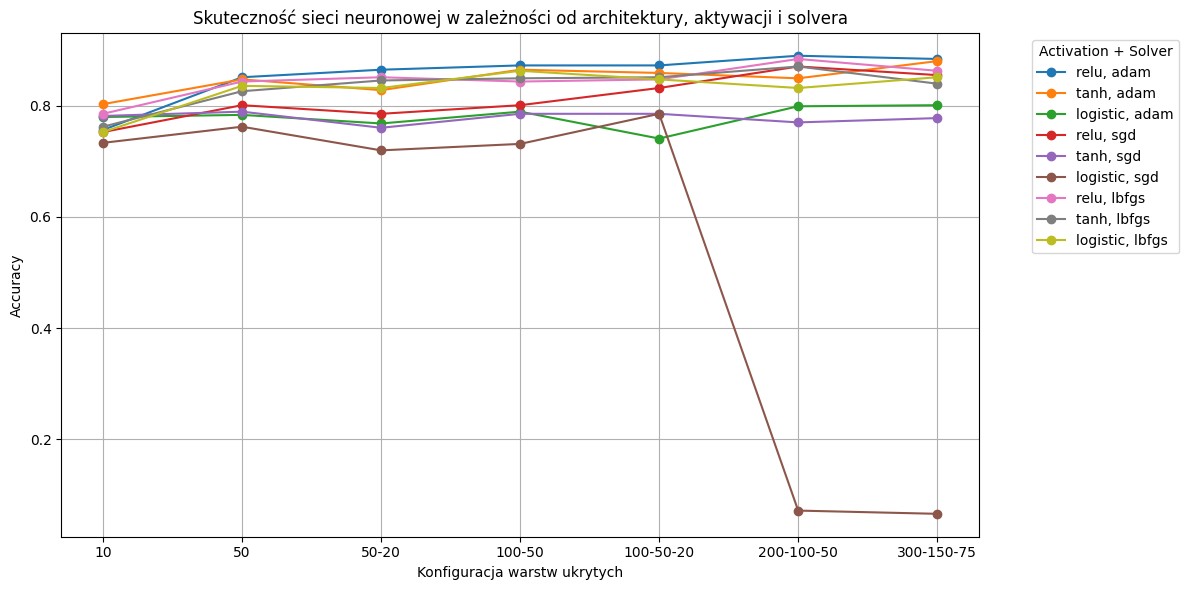

In [66]:
plt.figure(figsize=(12, 6))

results_nn_df['hidden_layers_str'] = results_nn_df['hidden_layers'].apply(lambda x: '-'.join(map(str, x)))

for solver in results_nn_df['solver'].unique():
    subset_solver = results_nn_df[results_nn_df['solver'] == solver]
    for activation in subset_solver['activation'].unique():
        subset = subset_solver[subset_solver['activation'] == activation]
        plt.plot(
            subset['hidden_layers_str'],
            subset['accuracy'],
            marker='o',
            label=f"{activation}, {solver}"
        )

plt.xlabel('Konfiguracja warstw ukrytych')
plt.ylabel('Accuracy')
plt.title('Skuteczność sieci neuronowej w zależności od architektury, aktywacji i solvera')
plt.legend(title='Activation + Solver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
results_nn_df = results_nn_df.sort_values('accuracy', ascending=False)
print("Top 5 wyników sieci neuronowej:")
for i, row in results_nn_df.head(5).iterrows():
    print(f"Hidden layers: {row['hidden_layers']}, Activation: {row['activation']}, Solver: {row['solver']}, Accuracy: {row['accuracy']:.4f}, Precision: {row['precision']:.4f}, Recall: {row['recall']:.4f}, F1-score: {row['f1_score']:.4f}]")

Top 5 wyników sieci neuronowej:
Hidden layers: (200, 100, 50), Activation: relu, Solver: adam, Accuracy: 0.8897, Precision: 0.8969, Recall: 0.8897, F1-score: 0.8932]
Hidden layers: (200, 100, 50), Activation: relu, Solver: lbfgs, Accuracy: 0.8839, Precision: 0.8956, Recall: 0.8839, F1-score: 0.8896]
Hidden layers: (300, 150, 75), Activation: relu, Solver: adam, Accuracy: 0.8839, Precision: 0.8870, Recall: 0.8839, F1-score: 0.8855]
Hidden layers: (300, 150, 75), Activation: tanh, Solver: adam, Accuracy: 0.8801, Precision: 0.9001, Recall: 0.8801, F1-score: 0.8894]
Hidden layers: (100, 50), Activation: relu, Solver: adam, Accuracy: 0.8723, Precision: 0.8850, Recall: 0.8723, F1-score: 0.8785]


In [69]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1]
best_hidden_layers = (50, 20)
best_activation = 'relu'
best_solver = 'adam'

results_nn_alpha = []
for alpha in alpha_values:
    mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layers, activation=best_activation, solver=best_solver, alpha=alpha, max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results_nn_alpha.append({
        'alpha': alpha,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })
results_alpha_df = pd.DataFrame(results_nn_alpha)


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

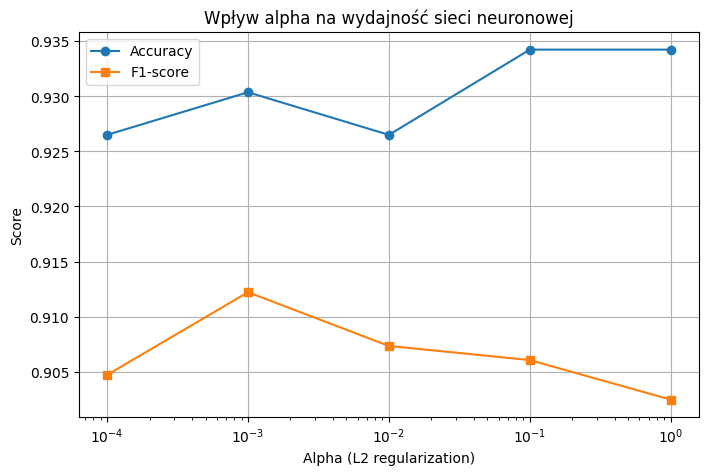

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(results_alpha_df['alpha'], results_alpha_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_alpha_df['alpha'], results_alpha_df['f1_score'], marker='s', label='F1-score')

plt.xscale('log')
plt.xlabel('Alpha (L2 regularization)')
plt.ylabel('Wynik')
plt.title('Wpływ alpha na wydajność sieci neuronowej')
plt.legend()
plt.grid(True)
plt.show()

### Fuzzy Logic

Z uwagi na fakt, że w regułach wnioskowania rozmytego liczba regół rośnie wykładniczo, a struktura systemu pozwala na modelowanie wnioskowania na podstawie wiedzy eksperckiej wybierzemy 3 cechy do uproszczonego systemu rozmytego:
- n_bumps
- gpuls
- energy

Wybrane cechy charakteryzują się silną korelacją z cechą decyzyjną i najlepiej odzwierciedlają istotne informacje dla procesu klasyfikacji.

In [78]:
y = df['class']
X = df[['nbumps','gpuls','energy']]

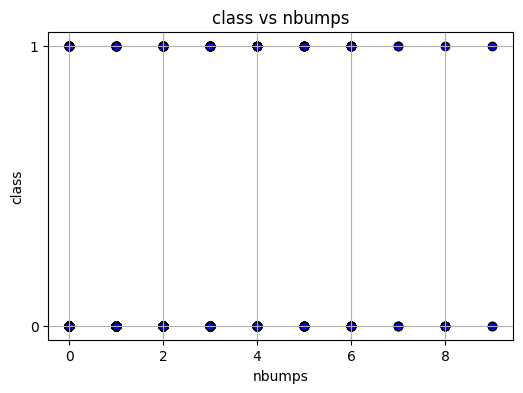

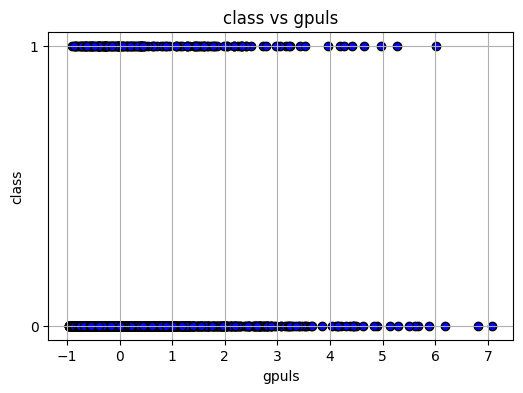

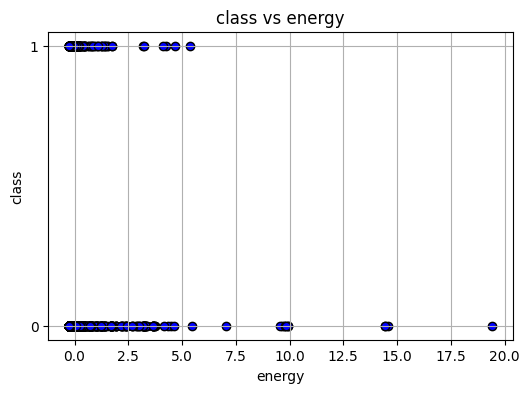

In [79]:
for col in X.columns:
      plt.figure(figsize=(6,4))
      plt.scatter(X[col], y, color='blue', edgecolor='k')
      plt.xlabel(col)
      plt.ylabel('class')
      plt.title(f'class vs {col}')
      plt.grid(True)
      plt.show()

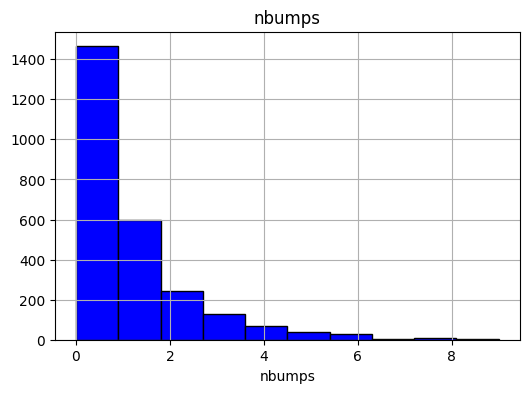

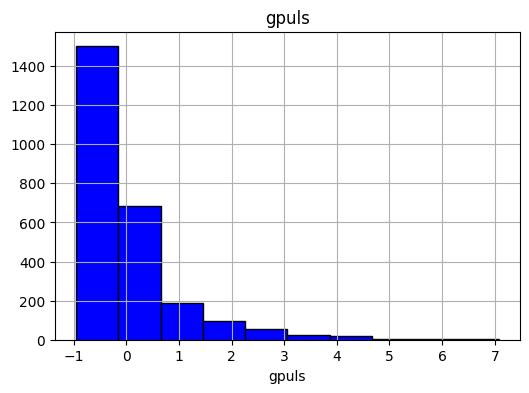

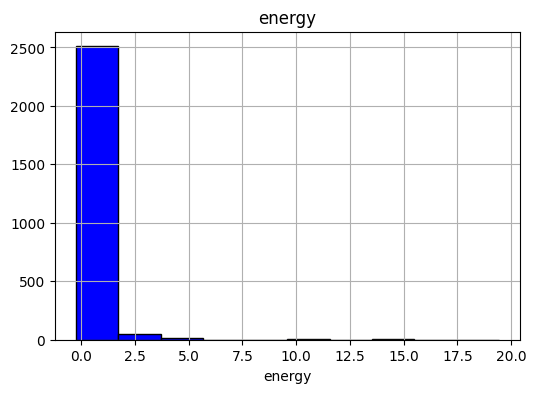

In [80]:
for col in X.columns:
      plt.figure(figsize=(6,4))
      plt.hist(X[col],color='blue', edgecolor='k')
      plt.xlabel(col)
      plt.title(f'{col}')
      plt.grid(True)
      plt.show()

Dla dobrego obrazowania wyników wybieramy funkcje trapezowe. Zrobimy też 3 poziomy każdej cechy.

In [146]:
import skfuzzy as fuzz

x_nbumps = np.arange(0, 9, 1)
nb0 = fuzz.trapmf(x_nbumps, [0, 0, 1, 2])
nb1 = fuzz.trapmf(x_nbumps, [1, 2, 4, 5])
nb2 = fuzz.trapmf(x_nbumps, [3, 5, 8, 9])
nb = np.vstack([nb0, nb1, nb2])

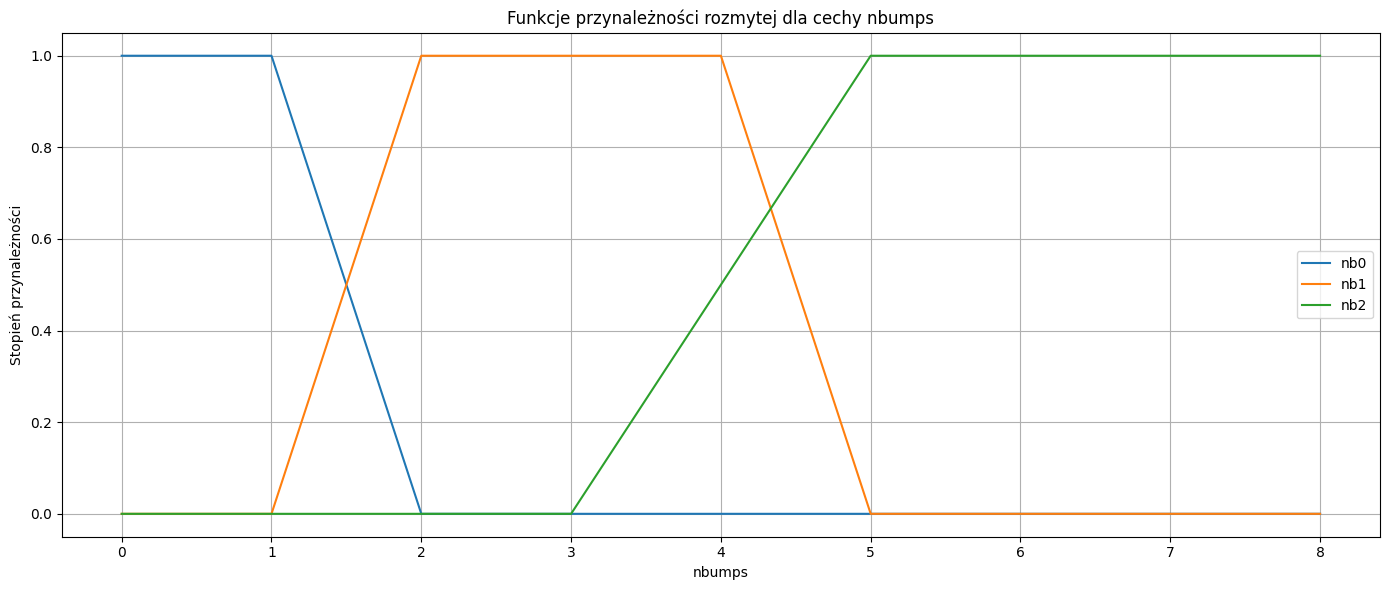

In [147]:
plt.figure(figsize=(14, 6))

plt.plot(x_nbumps, nb0, label="nb0")
plt.plot(x_nbumps, nb1, label="nb1")
plt.plot(x_nbumps, nb2, label="nb2")

plt.title("Funkcje przynależności rozmytej dla cechy nbumps")
plt.xlabel("nbumps")
plt.ylabel("Stopień przynależności")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [148]:
x_gpuls = np.arange(-1, 7, 1)
gp0 = fuzz.trapmf(x_gpuls, [-1, -1, 0, 1])
gp1 = fuzz.trapmf(x_gpuls, [0, 1, 3, 4])
gp2 = fuzz.trapmf(x_gpuls, [2, 4, 7, 7])
gp = np.vstack([gp0, gp1, gp2])

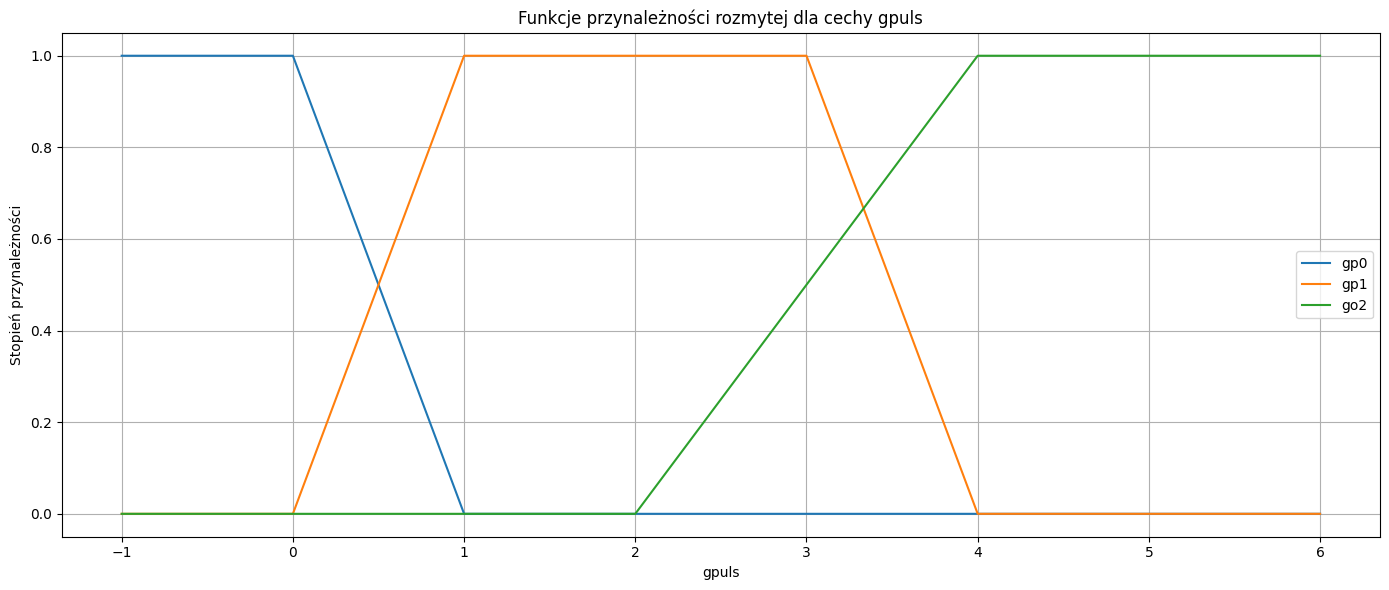

In [149]:
plt.figure(figsize=(14, 6))

plt.plot(x_gpuls, gp0, label="gp0")
plt.plot(x_gpuls, gp1, label="gp1")
plt.plot(x_gpuls, gp2, label="go2")

plt.title("Funkcje przynależności rozmytej dla cechy gpuls")
plt.xlabel("gpuls")
plt.ylabel("Stopień przynależności")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [166]:
x_energy = np.arange(0, 20, 0.5)
e0 = fuzz.trapmf(x_energy, [0, 0, 0.5, 2])
e1 = fuzz.trapmf(x_energy, [1, 3.5, 7, 10])
e2 = fuzz.trapmf(x_energy, [3.5, 10, 20, 20])
e = np.vstack([e0, e1, e2])

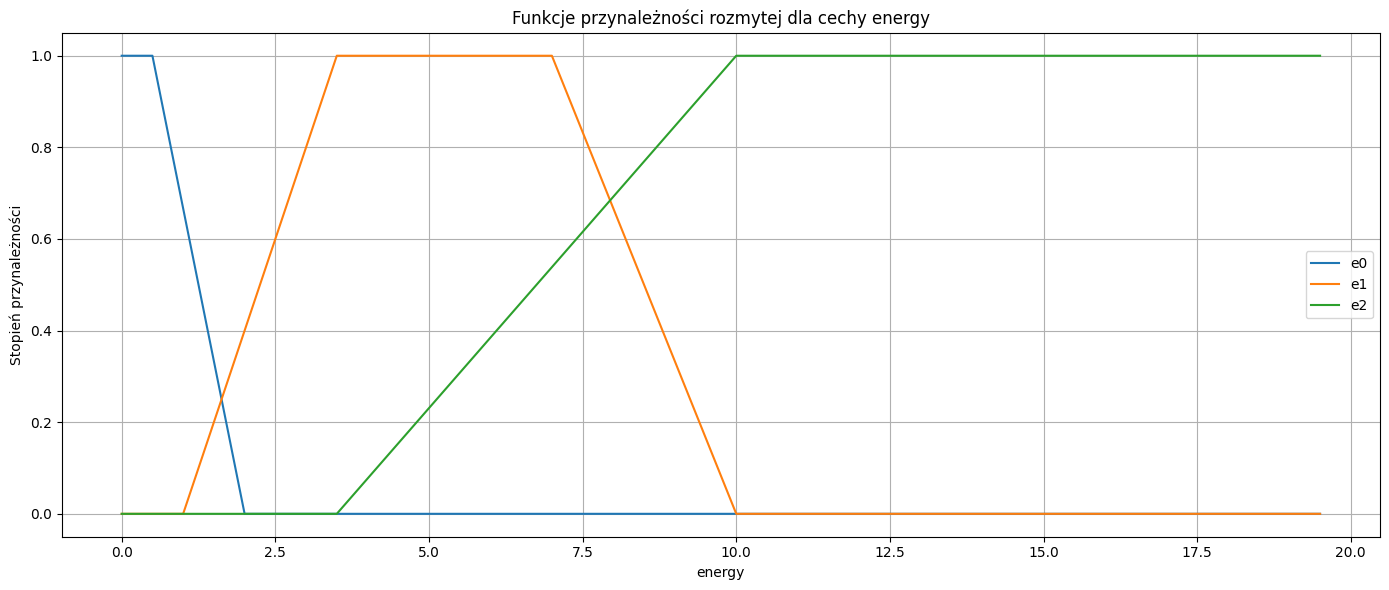

In [167]:
plt.figure(figsize=(14, 6))

plt.plot(x_energy, e0, label="e0")
plt.plot(x_energy, e1, label="e1")
plt.plot(x_energy, e2, label="e2")

plt.title("Funkcje przynależności rozmytej dla cechy energy")
plt.xlabel("energy")
plt.ylabel("Stopień przynależności")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [168]:
x_bump = np.arange(0, 1.1, 0.1)

bump_no = fuzz.trimf(x_bump, [0, 0, 0.5])
bump_yes = fuzz.trimf(x_bump, [0.5, 1, 1])

In [169]:
import skfuzzy.control as ctrl
energy_ctrl = ctrl.Antecedent(x_energy, 'energy')
gpuls_ctrl = ctrl.Antecedent(x_gpuls, 'gpuls')
nbumps_ctrl = ctrl.Antecedent(x_nbumps, 'nbumps')
bump_ctrl = ctrl.Consequent(x_bump, 'bump')

energy_ctrl['low'] = e0
energy_ctrl['medium'] = e1
energy_ctrl['high'] = e2

gpuls_ctrl['low'] = gp0
gpuls_ctrl['medium'] = gp1
gpuls_ctrl['high'] = gp2

nbumps_ctrl['low'] = nb0
nbumps_ctrl['medium'] = nb1
nbumps_ctrl['high'] = nb2

bump_ctrl['no'] = bump_no
bump_ctrl['yes'] = bump_yes

In [174]:
rules = []

levels = ['low', 'medium', 'high']

for e_level in levels:
    for g_level in levels:
        for n_level in levels:
            # logika decyzyjna:
            high_count = sum([e_level=='high', g_level=='high', n_level=='high'])
            if high_count >= 1:
                rules.append(ctrl.Rule(
                    energy_ctrl[e_level] & gpuls_ctrl[g_level] & nbumps_ctrl[n_level],
                    bump_ctrl['yes']
                ))
            else:
                rules.append(ctrl.Rule(
                    energy_ctrl[e_level] & gpuls_ctrl[g_level] & nbumps_ctrl[n_level],
                    bump_ctrl['no']
                ))

Predicted bump: 0.825


C:\Users\grazi\AppData\Roaming\Python\Python314\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


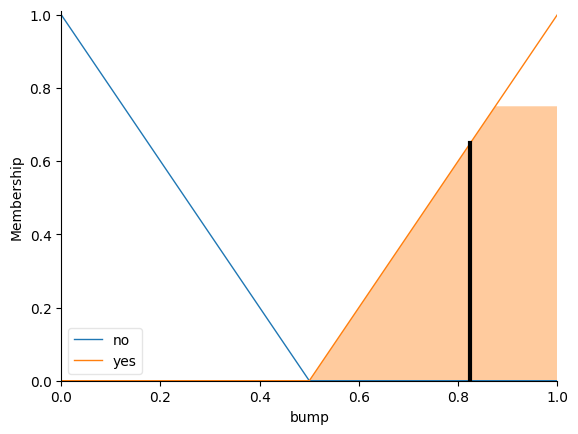

In [175]:
bump_system = ctrl.ControlSystem(rules)
bump_sim = ctrl.ControlSystemSimulation(bump_system)

# Przykład predykcji
bump_sim.input['energy'] = 10
bump_sim.input['gpuls'] = 3.5
bump_sim.input['nbumps'] = 4

bump_sim.compute()
print("Predicted bump:", bump_sim.output['bump'])

# Wykres wyjścia
bump_ctrl.view(sim=bump_sim)


In [176]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [178]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predicted_classes = []

for i in range(len(X_test)):
    energy_val = X_test.iloc[i]['energy']
    nbumps_val = X_test.iloc[i]['nbumps']
    gpuls_val = X_test.iloc[i]['gpuls']
    
    bump_sim.reset()
    
    bump_sim.input['energy'] = energy_val
    bump_sim.input['nbumps'] = nbumps_val
    bump_sim.input['gpuls'] = gpuls_val
    
    bump_sim.compute()
    
    pred_class = bump_sim.output.get('bump') 
    pred_class = int(round(pred_class))
    predicted_classes.append(pred_class)
y_test_int = y_test.astype(int)

acc = accuracy_score(y_test_int, predicted_classes)
print(f"Dokładność: {acc:.4f}\n")

f1 = f1_score(y_test_int, predicted_classes, average='weighted')
print(f"F1-score: {f1:.4f}\n")

cm = confusion_matrix(y_test_int, predicted_classes)
print("Macierz pomyłek:\n", cm, "\n")

print(classification_report(y_test_int, predicted_classes))

Dokładność: 0.9091

F1-score: 0.9008

Macierz pomyłek:
 [[465  18]
 [ 29   5]] 

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       483
           1       0.22      0.15      0.18        34

    accuracy                           0.91       517
   macro avg       0.58      0.55      0.56       517
weighted avg       0.89      0.91      0.90       517



In [183]:
final_results = pd.DataFrame({
    "Model": [
        "KNN",
        "KNN (SMOTE)",
        "Naive Bayes",
        "Naive Bayes (SMOTE)",
        "SVM",
        "SVM (SMOTE)",
        "MLP",
        "MLP (SMOTE)",
        "Fuzzy Logic System"
    ],
    "Accuracy": [
        0.9381,
        0.8491,
        0.8685,
        0.9130,
        0.9342,
        0.9091,
        0.9362,
        0.8897,
        0.9091
    ],
    "F1-score": [
        0.9116,
        0.8723,
        0.8840,
        0.9067,
        0.9025,
        0.9026,
        0.9160,
        0.8932,
        0.9008
    ]
})

final_results

Model  Accuracy  F1-score
0                  KNN    0.9381    0.9116
1          KNN (SMOTE)    0.8491    0.8723
2          Naive Bayes    0.8685    0.8840
3  Naive Bayes (SMOTE)    0.9130    0.9067
4                  SVM    0.9342    0.9025
5          SVM (SMOTE)    0.9091    0.9026
6                  MLP    0.9362    0.9160
7          MLP (SMOTE)    0.8897    0.8932
8   Fuzzy Logic System    0.9091    0.9008

In [188]:
import pandas as pd

plot_df = final_results.copy()

plot_df["SMOTE"] = plot_df["Model"].str.contains("SMOTE")
plot_df["BaseModel"] = plot_df["Model"].str.replace(" \\(SMOTE\\)", "", regex=True)



In [189]:
plot_df = plot_df.melt(
    id_vars=["BaseModel", "SMOTE"],
    value_vars=["Accuracy", "F1-score"],
    var_name="Metric",
    value_name="Value"
)


C:\Users\grazi\AppData\Local\Temp\ipykernel_41040\255838945.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


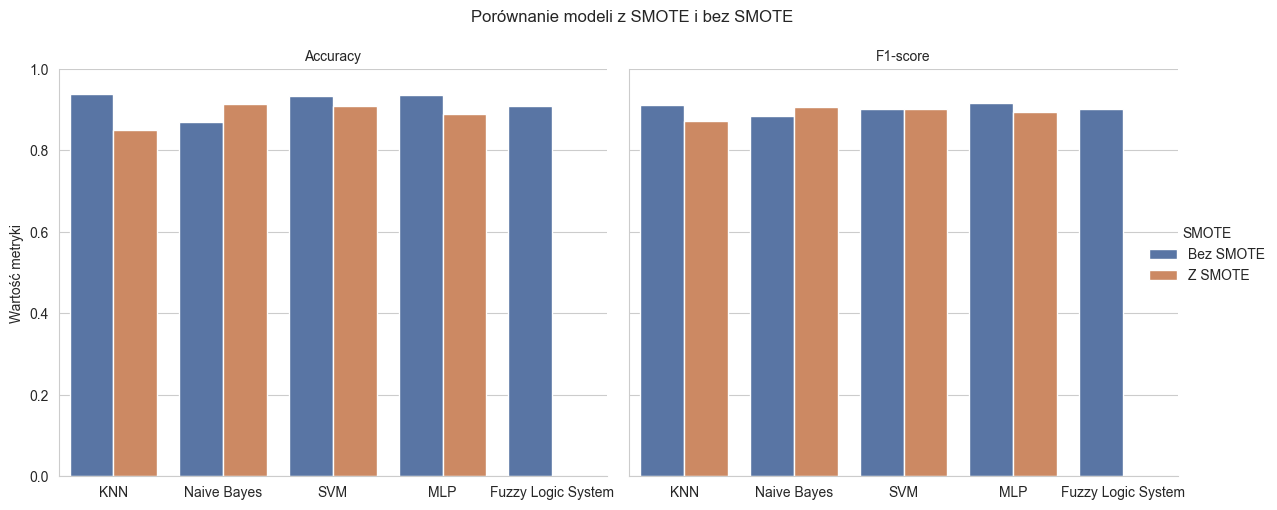

In [191]:
g = sns.catplot(
    data=plot_df,
    x="BaseModel",
    y="Value",
    hue="SMOTE",
    col="Metric",
    kind="bar",
    height=5,
    aspect=1.2,
    palette={False: "#4C72B0", True: "#DD8452"},
    ci=None
)

g.set_titles("{col_name}")
g.set_axis_labels("", "Wartość metryki")
g.set(ylim=(0, 1))
g._legend.set_title("SMOTE")
g._legend.texts[0].set_text("Bez SMOTE")
g._legend.texts[1].set_text("Z SMOTE")

plt.suptitle("Porównanie modeli z SMOTE i bez SMOTE", y=1.05)
plt.show()
